# Applied Data Science and Machine Intelligence
## A program by IIT Madras and TalentSprint
### Module 2 Mini Project: Sentiment Analysis using linear classifiers and unsupervised clustering.

## Learning Objectives

At the end of the mini project, you will be able to -

* use a real world dataset.
* undertake several important steps like cleaning the data and normalizing the data points.
* do sentiment classification.
* compare between different types of classification methods and their pros and cons.
* compare between supervised and unsupervised (clustering) techniques.

### Goal of the project
The goal of this project is to train linear classification models that can recognize the sentiment of the reviewer. In this project we will be dealing with only positive and negative sentiments (binary classification).

**Disclaimer**:
There are multiple ways to solve this problem, as there is no unique formula to solve.
This is just one such approach.


**Packages used:**  
* `Pandas` for data frames and easy to read csv files  
* `Numpy` for array and matrix mathematics functions  
* `Matplotlib` and `Seaborn` for visualization
*  `sklearn` for the metrics and pre-processing
* `scipy` for helper functions required at various stages of the project.
* `warnings` is used to supress warnings from different libraries used in the project.

In [1]:
#pip install -r requirements.txt

### Importing the packages

In [2]:
# Importing standard libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import zipfile
import requests
import os
from tqdm import tqdm 
import matplotlib.pyplot as plt

# Preprocessing 
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import spacy
import string
import nltk
from nltk.corpus import stopwords

# Embedding 
from collections import Counter
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

#PCA Transform 
from sklearn.decomposition import PCA

# Importing linear classification algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.ensemble import RandomForestClassifier as SKRandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Importing preprocessing functions
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Importing metrics
from sklearn.metrics import accuracy_score as calculate_accuracy
from sklearn.metrics import f1_score as calculate_f1_score

# Suppressing warnings
import warnings
warnings.filterwarnings('ignore')


### Downloading a dataset containing amazon review information along with ratings

In [3]:
def download_file(url, save_path, chunk_size=128):
    """
    Downloads a file from a URL and saves it to the specified path.

    Args:
        url (str): The URL of the file to download.
        save_path (str): The path where the file should be saved.
        chunk_size (int): The size of each chunk for streaming download (default is 128 bytes).
    """
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        
        total_size = int(response.headers.get('content-length', 0))
        progress_bar = tqdm(total=total_size, unit='B', unit_scale=True)
        
        with open(save_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=chunk_size):
                if chunk:
                    file.write(chunk)
                    progress_bar.update(len(chunk))
        
        progress_bar.close()
        
        print(f"Downloaded to: {save_path}")
    
    except requests.exceptions.RequestException as e:
        print(f"Download failed: {str(e)}")


def unzip_file(zip_file_path, extract_to_path):
    """
    Unzips a zip file to a specified directory.

    Args:
        zip_file_path (str): Path to the zip file.
        extract_to_path (str): Directory where the contents will be extracted.
    """
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to_path)
        print(f"Successfully extracted to: {extract_to_path}")
    except Exception as e:
        print(f"Extraction failed: {str(e)}")

In [4]:
url="https://cdn.iisc.talentsprint.com/ADSMI/Datasets/amazon_reviews.zip"

In [5]:

# Folder File Paths
zip_folder=os.path.join(os.getcwd(),'Data','downloaded_data','zip')
unzip_folder=os.path.join(os.getcwd(),'Data','Ingested_data','data')

#  Folder to Download and Unzip Data
os.makedirs(zip_folder,exist_ok=True)
os.makedirs(unzip_folder,exist_ok=True)

# Downloading and Unzipping the data 
download_save_path=os.path.join(zip_folder,'amazon_reviews.zip')
unzip_file_path=unzip_folder

In [6]:
download_file(url=url,save_path=download_save_path,)
unzip_file(zip_file_path=download_save_path,extract_to_path=unzip_file_path)

100%|██████████| 29.9M/29.9M [00:03<00:00, 7.76MB/s]


Downloaded to: e:\Projects\IIT Madras\Data\downloaded_data\zip\amazon_reviews.zip
Successfully extracted to: e:\Projects\IIT Madras\Data\Ingested_data\data


## How does the dataset look like?
Lets use a standard dataset from Amazon which contains reviews and ratings from the customer. 
The original dataset has three features: name(name of the products), review(Customer reviews of the products), and rating(rating of the customer of a product ranging from 1 to 5). 

The review column will be the input column and the rating column will be used to understand the sentiments of the review. Here are some important data preprocessing steps:
The dataset has about 183,500 rows of data. There are 1147 null values which will be removed.
As the dataset is pretty big, it takes a lot of time to run some machine learning algorithms. We will use 30% of the data in this project which is still 54,000+ data points! The sample will be representative of the whole dataset.


If the rating is 1 and 2 that will be considered a negative review. 
And if the review is 3, 4, and 5, the review will be considered as a  positive review. We add a new column named ‘sentiments’ to the dataset that will use 1 for the positive reviews and 0 for the negative reviews. We read and display the contents of the dataset down below.

**Exercise 1**: Load the data and perform the following (1 points)
- Exploratory Data Analysis
- Preprocessing

Reading Data from Folder

In [7]:
data_file_path=os.path.join(unzip_file_path,'amazon_reviews.csv')
df=pd.read_csv(data_file_path)

In [8]:
df.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


Shape of the Data 

In [9]:
df.shape

(183531, 3)

### Target Column

In [10]:
def label_sentiments(df, rating_column, sentiment_column):
    """
    Label sentiments based on ratings and add a new column to the DataFrame.
    
    Args:
    - df (pd.DataFrame): The DataFrame containing the reviews and ratings.
    - rating_column (str): The name of the column containing the ratings.
    - sentiment_column (str): The name of the column to store sentiment labels.
    
    Returns:
    - pd.DataFrame: The DataFrame with sentiment labels.
    """
    # Create a mapping of ratings to sentiments
    rating_sentiment_map = {1: 0, 2: 0, 3: 1, 4: 1, 5: 1}
    
    # Apply the mapping to create the 'sentiments' column
    df[sentiment_column] = df[rating_column].map(rating_sentiment_map)

    # Dropping Rating Column

    df.drop(columns=['rating'],axis=1,inplace=True)
    
    return df

In [11]:
df=label_sentiments(df=df,rating_column='rating',sentiment_column='sentiment')

In [12]:
df.shape

(183531, 3)

Trim data

This function takes as input a Pandas DataFrame containing a binary classification dataset, where one column specifies the target labels. It aims to balance the dataset by reducing the size of the majority class while retaining a specified proportion of the majority class data.

- data: The input Pandas DataFrame containing the dataset.
- target_column: Name of the column specifying the target labels (binary classification).
- retention_rate: A parameter that sets the minimum retention rate (between 0.0 and 1.0) for the majority class data.

In [13]:
def trim_data_with_retention(data, target_column, retention_rate=0.8):
    """
    Trim the majority class data to balance the target classes while retaining a specified data retention rate.

    Parameters:
    - data: Pandas DataFrame containing the dataset.
    - target_column: Name of the target column (binary classification).
    - retention_rate: Minimum retention rate for the majority class data (0.0 to 1.0).

    Returns:
    - Pandas DataFrame with trimmed data to balance classes and meet the retention rate.
    """
    # Count the number of samples in each class
    class_counts = data[target_column].value_counts()

    # Find the minority and majority class labels
    minority_class_label = class_counts.idxmin()
    majority_class_label = class_counts.idxmax()

    # Get the data for minority and majority classes
    minority_class_data = data[data[target_column] == minority_class_label]
    majority_class_data = data[data[target_column] == majority_class_label]

    # Calculate the desired size of the majority class data
    desired_majority_size = int(len(minority_class_data) / retention_rate)

    # Trim the majority class data to the desired size
    trimmed_majority_class_data = majority_class_data.sample(n=desired_majority_size)

    # Concatenate the minority and trimmed majority class data
    balanced_data = pd.concat([minority_class_data, trimmed_majority_class_data])

    return balanced_data

In [14]:
df=trim_data_with_retention(data=df,target_column='sentiment')

In [15]:
df.shape

(59609, 3)

In [16]:
def plot_sentiments(df, sentiment_column):
    """
    Plot sentiment labels with positive and negative labels on the plot.
    
    Args:
    - df (pd.DataFrame): The DataFrame containing the sentiments and reviews.
    - sentiment_column (str): The name of the column containing sentiment labels.
    """
    # Count the number of positive and negative sentiments
    sentiment_counts = df[sentiment_column].value_counts()

    # Create a bar plot with seaborn
    plt.figure(figsize=(8, 6))
    sns.set(style="whitegrid")
    ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="Set1")

    # Customize plot appearance
    ax.set_xlabel("Sentiment", fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.set_title("Sentiment Analysis", fontsize=16)

    # Set labels for the x-axis
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Negative(0)", "Positive(1)"], fontsize=12)

    # Add labels "0" and "1" on top of the bars
    for i, count in enumerate(sentiment_counts.values):
        ax.text(i, count + 10, str(count), ha='center', fontsize=12)

    # Beautify the plot
    sns.despine(left=True, bottom=True)
    
    # Display the plot
    plt.show()


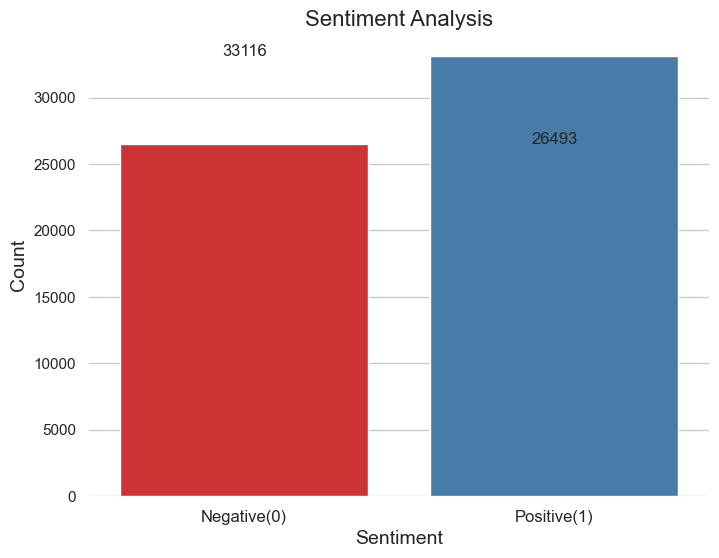

In [17]:
plot_sentiments(df=df,sentiment_column='sentiment')

Splitting Train and Test Data

The split_balanced_data function is designed to split a balanced dataset, typically used for binary classification tasks, into training and testing sets while ensuring that the class distribution remains balanced in both sets. It takes the following parameters:

- data: A Pandas DataFrame containing the balanced dataset.
- target_column: The name of the target column representing the binary classification labels.
- test_size: The proportion of the data to include in the test split, specified as a value between 0.0 and 1.0 (default is 0.2, meaning a 80-20 train-test      split).
- random_state: An optional seed for reproducibility (an integer).

In [18]:
def split_balanced_data(data, target_column, test_size=0.2, random_state=None):
    """
    Split the balanced data into training and testing sets while maintaining class balance.

    Parameters:
    - data: Pandas DataFrame containing the balanced dataset.
    - target_column: Name of the target column (binary classification).
    - test_size: Proportion of the data to include in the test split (0.0 to 1.0).
    - random_state: Seed for reproducibility (int).

    Returns:
    - train_df: Pandas DataFrame for the training set.
    - test_df: Pandas DataFrame for the testing set.
    """
    # Separate data into minority and majority classes
    minority_class = data[data[target_column] == 1]
    majority_class = data[data[target_column] == 0]

    # Split both minority and majority classes into training and testing
    minority_train, minority_test = train_test_split(minority_class, test_size=test_size, random_state=random_state)
    majority_train, majority_test = train_test_split(majority_class, test_size=test_size, random_state=random_state)

    # Concatenate the training and testing sets while maintaining balance
    train_df = pd.concat([minority_train, majority_train])
    test_df = pd.concat([minority_test, majority_test])

    return train_df, test_df


train_df, test_df=split_balanced_data(data=df,target_column='sentiment')

Duplicate Values

In [19]:
def duplicate_rows(data_frame):
    """
    Finds and plots a bar graph for duplicate and non-duplicate rows in a DataFrame.

    Args:
        data_frame (pd.DataFrame): The DataFrame in which to find duplicate rows and plot the graph.
    """
    # Find duplicate rows
    duplicate_rows = data_frame[data_frame.duplicated()]

    # Calculate the count of duplicate and non-duplicate rows
    duplicate_count = len(duplicate_rows)
    non_duplicate_count = len(data_frame) - duplicate_count

    # Calculate the percentages
    total_count = len(data_frame)
    duplicate_percentage = (duplicate_count / total_count) * 100
    non_duplicate_percentage = (non_duplicate_count / total_count) * 100

    # Plot the graph
    plt.bar(['Duplicate Rows', 'Non-Duplicate Rows'], [duplicate_count, non_duplicate_count])
    plt.xlabel('Row Type')
    plt.ylabel('Count')
    plt.title('Duplicate vs. Non-Duplicate Rows')
    
    # Add percentage labels to the bars
    plt.text(0, duplicate_count, f'{duplicate_percentage:.2f}%', ha='center', va='bottom')
    plt.text(1, non_duplicate_count, f'{non_duplicate_percentage:.2f}%', ha='center', va='bottom')
    
    plt.show()

    if duplicate_count > 0:
        print("Duplicate rows found:")
        print(duplicate_rows)
    else:
        print("No duplicate rows found.")

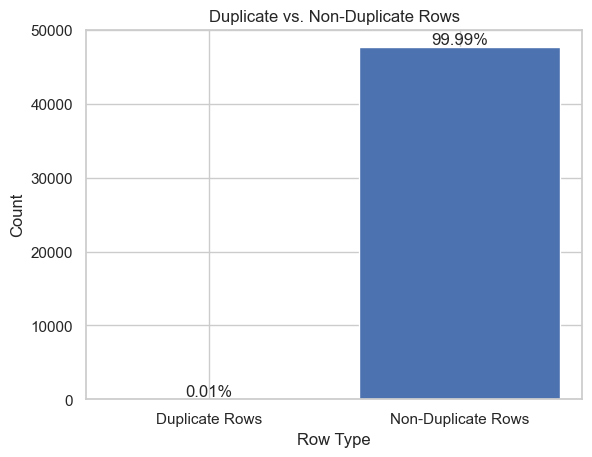

Duplicate rows found:
                                                     name review  sentiment
13306     North States Superyard Play Yard, Grey, 6 Panel    NaN          1
31762              Regalo My Cot Portable Bed, Royal Blue    NaN          1
149883  Dream On Me 3&quot; Foam Graco Pack 'n Play Ma...    NaN          1


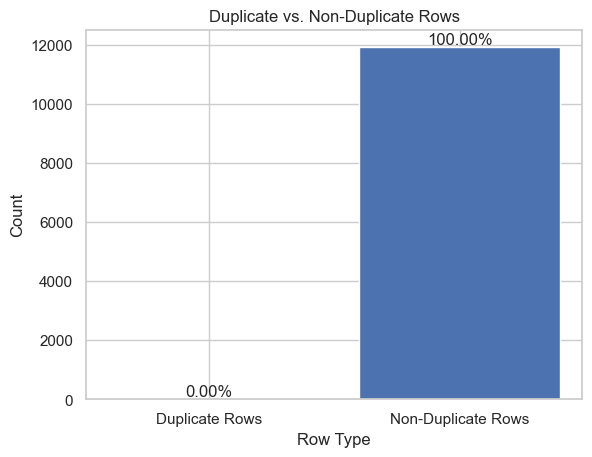

No duplicate rows found.


In [20]:
duplicate_rows(data_frame=train_df)
duplicate_rows(data_frame=test_df)

Drop Duplicate Rows

In [21]:
def drop_duplicate_rows(data_frame):
    """
    Drops duplicate rows from a DataFrame and returns a new DataFrame with duplicates removed.

    Args:
        data_frame (pd.DataFrame): The DataFrame from which to remove duplicate rows.

    Returns:
        pd.DataFrame: A new DataFrame with duplicate rows removed.
    """
    # Use the drop_duplicates() method to remove duplicates
    cleaned_data_frame = data_frame.drop_duplicates()
    
    return cleaned_data_frame
train_df=drop_duplicate_rows(data_frame=train_df)
test_df=drop_duplicate_rows(data_frame=test_df)


In [22]:
train_df.shape


(47683, 3)

In [23]:
test_df.shape

(11923, 3)

NAN Values

In [24]:
def plot_nan_percentage(data_frame):
    """
    Plots the percentage of NaN (missing) values in each column of a DataFrame.

    Args:
        data_frame (pd.DataFrame): The DataFrame for which to plot NaN values percentage.
    """
    # Calculate the percentage of NaN values in each column
    nan_percentage = (data_frame.isnull().sum() / len(data_frame)) * 100

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    nan_percentage.plot(kind='bar')
    
    # Labels and title
    plt.xlabel('Columns')
    plt.ylabel('Percentage of NaN Values')
    plt.title('Percentage of NaN Values in Each Column')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)
    
    # Ensure tight layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()

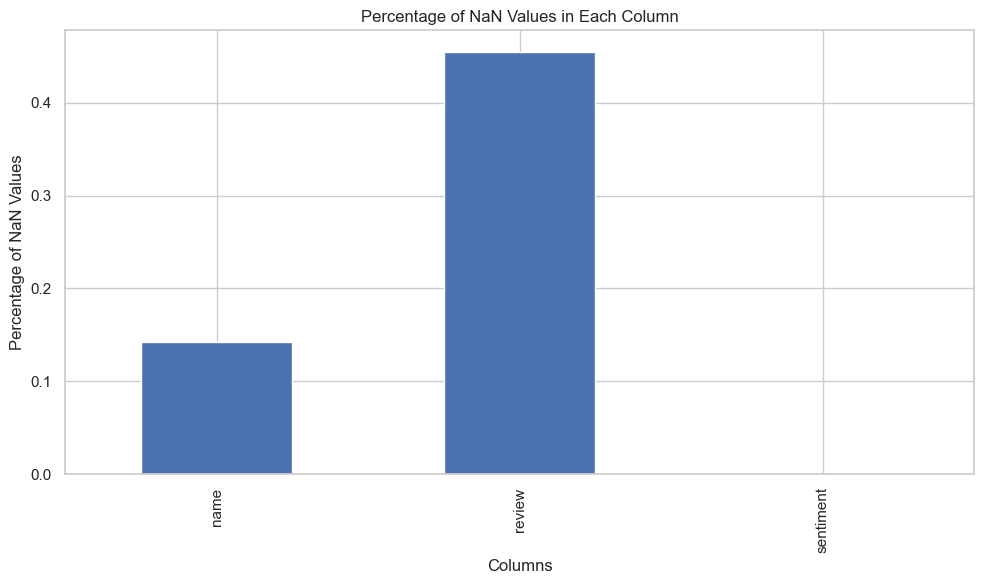

In [25]:
plot_nan_percentage(data_frame=train_df)

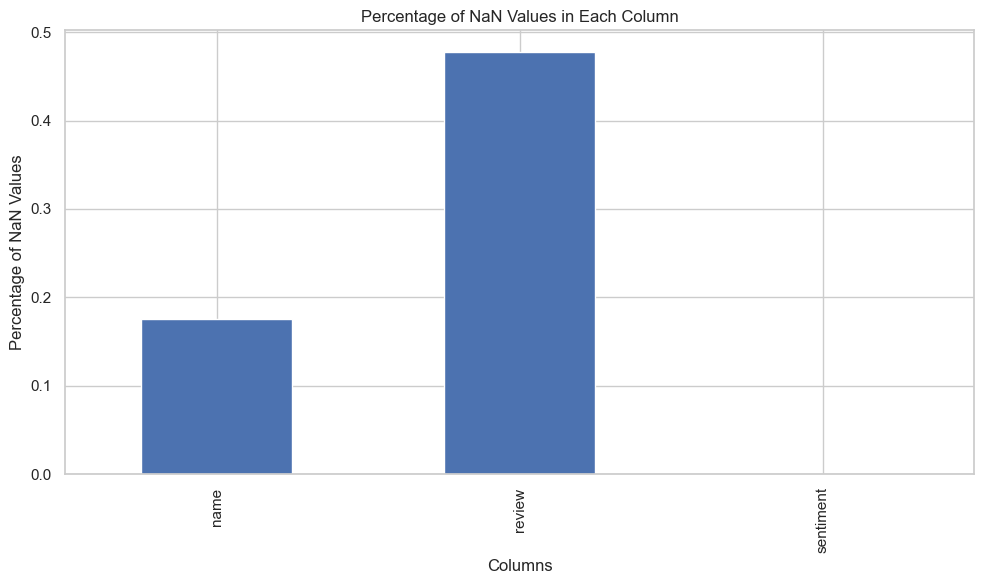

In [26]:
plot_nan_percentage(data_frame=test_df)

In [27]:
def drop_nan_rows(df):
    # Print the shape before dropping NaN rows
    print("Shape before dropping NaN rows:", df.shape)
    
    # Drop rows with NaN values
    df = df.dropna()
    
    # Print the shape after dropping NaN rows
    print("Shape after dropping NaN rows:", df.shape)
    
    return df

train_df=drop_nan_rows(df=train_df)
test_df=drop_nan_rows(df=test_df)

Shape before dropping NaN rows: (47683, 3)
Shape after dropping NaN rows: (47398, 3)
Shape before dropping NaN rows: (11923, 3)
Shape after dropping NaN rows: (11845, 3)


Dropping NAN values as the percentage of NAn values is less

In [28]:
train_df

,name,review,sentiment
178324,Skip Hop Giraffe Safari Activity Toy,This toy is made like a rag doll. The sewn sea...,1
2522,BABYBJORN Toilet Trainer - White/Red,The seat is very comfortable and my 2-years ol...,1
73573,Regalo Easy Open 50 Inch Super Wide Walk Thru ...,Very easy to install! Feels a tad flimsy when ...,1
120677,26-Piece Foam Puzzle Play Mat - Solid Colored,I bought these for my five month old because w...,1
123821,"Evenflo Titan Sport Convertible Seat, Willow",I purchased this carseat as a gift for a frien...,1
...,...,...,...
152405,"Skip Hop Zoo Little Kid Luggage, Dog",This item was received with a blue stain on th...,0
163399,CHILL BABY Mustache Pacifier,Please read up on the recalls on the Chill Bab...,0
125699,"The First Years Double Sponge Bottle Brush, Black",This brush looked great when I ordered it. It ...,0
138024,Bright Starts Sweet Jubilee Bouncer,"This thing is defective, and if it wasn't for ...",0


Target Column - 'Sentiment'

In [29]:
def plot_sentiments(df, sentiment_column):
    """
    Plot sentiment labels with positive and negative labels on the plot.
    
    Args:
    - df (pd.DataFrame): The DataFrame containing the sentiments and reviews.
    - sentiment_column (str): The name of the column containing sentiment labels.
    """
    # Count the number of positive and negative sentiments
    sentiment_counts = df[sentiment_column].value_counts()

    # Create a bar plot with seaborn
    plt.figure(figsize=(8, 6))
    sns.set(style="whitegrid")
    ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="Set1")

    # Customize plot appearance
    ax.set_xlabel("Sentiment", fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.set_title("Sentiment Analysis", fontsize=16)

    # Set labels for the x-axis
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Negative(0)", "Positive(1)"], fontsize=12)

    # Add labels "0" and "1" on top of the bars
    for i, count in enumerate(sentiment_counts.values):
        ax.text(i, count + 10, str(count), ha='center', fontsize=12)

    # Beautify the plot
    sns.despine(left=True, bottom=True)
    
    # Display the plot
    plt.show()


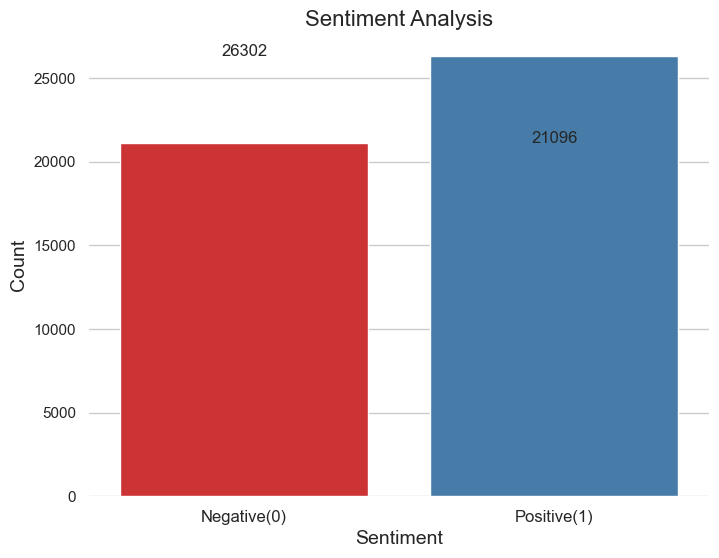

In [30]:

plot_sentiments(df=train_df,sentiment_column='sentiment')

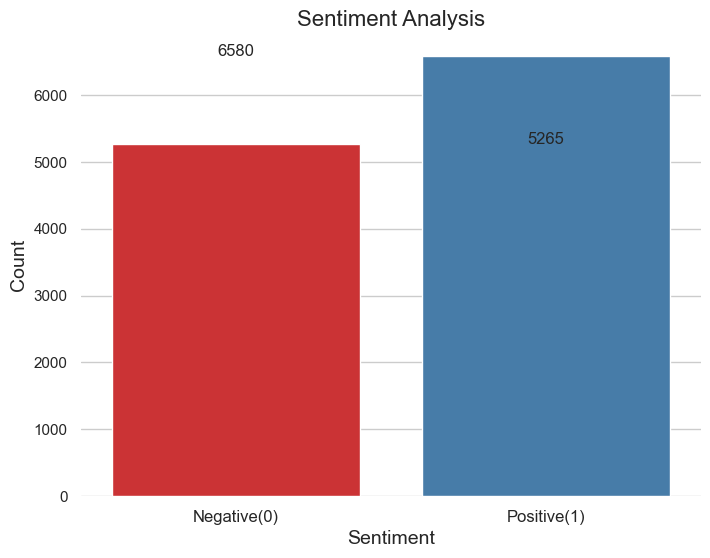

In [31]:
plot_sentiments(df=test_df,sentiment_column='sentiment')

Dropping the Product column 

Dropping product column as it is not significant for sentiment analysis

In [32]:
train_df.drop(columns=['name'],axis=1,inplace=True)
test_df.drop(columns=['name'],axis=1,inplace=True)

### Basic Preprocessing



- Removing Punctuation: 
    Eliminating punctuation marks to ensure that the text is free from non-alphanumeric characters like periods and commas.

- Removing Special Characters: 
    Getting rid of special characters, symbols, and emojis to simplify and standardize the text.

- Removing Stopwords: 
    Omitting common words like "and," "the," and "in" that don't carry significant meaning in isolation, in order to focus on the core content.

- Lowercasing: 
    Converting all text to lowercase to ensure uniformity and prevent the model from treating differently cased words as distinct.

In [33]:

class TextPreprocessor:
    def __init__(self, df, column_label):
        self.df = df
        self.column_label = column_label
        self.punctuation_translator = str.maketrans('', '', string.punctuation)
        nltk.download('stopwords')
        self.stopwords_set = set(stopwords.words('english'))

    def remove_punctuation(self):
        self.df[self.column_label] = self.df[self.column_label].apply(lambda x: x.translate(self.punctuation_translator))
    
    def remove_special_characters(self):
        self.df[self.column_label] = self.df[self.column_label].apply(lambda x: ''.join(e for e in x if e.isalnum() or e.isspace()))
    
    def remove_stopwords(self):
        self.df[self.column_label] = self.df[self.column_label].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in self.stopwords_set]))
    
    def lowercase(self):
        self.df[self.column_label] = self.df[self.column_label].apply(lambda x: x.lower())

    def processed_data(self):
        return self.df

Preprocessing - Train and Test Data

In [34]:
# Initialize the TextPreprocessor class
text_processor = TextPreprocessor(train_df, 'review')


# Perform text preprocessing tasks
text_processor.remove_punctuation()
text_processor.remove_special_characters()
text_processor.remove_stopwords()
text_processor.lowercase()


train_df=text_processor.processed_data()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hitesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
# Initialize the TextPreprocessor class
text_processor = TextPreprocessor(test_df, 'review')


# Perform text preprocessing tasks
text_processor.remove_punctuation()
text_processor.remove_special_characters()
text_processor.remove_stopwords()
text_processor.lowercase()


test_df=text_processor.processed_data()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hitesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Lemmetization


Lemmatization is a natural language processing technique used to reduce words to their base or root form, known as a lemma. Unlike stemming, which simply chops off prefixes or suffixes from words, lemmatization considers the word's context and grammatical meaning to produce a valid word form. This process helps in standardizing words, making it easier to analyze and understand text data. For example, the lemmatization of the word "running" would result in "run," ensuring that different inflections of a word are treated as the same, facilitating more accurate and meaningful text analysis and language understanding.

In [36]:
class DataFrameLemmatizer:
    def __init__(self, model_name="en_core_web_sm"):
        """
        Initialize the DataFrameLemmatizer.

        Args:
            model_name (str): The name of the spaCy language model to load.
        """
        self.nlp = spacy.load(model_name)

    def lemmatize_text(self, text):
        """
        Lemmatize a text using spaCy.

        Args:
            text (str): The input text to be lemmatized.

        Returns:
            str: The lemmatized text.
        """
        doc = self.nlp(text)
        lemmatized_text = " ".join([token.lemma_ for token in doc])
        return lemmatized_text

    def lemmatize_dataframe_column(self, dataframe, column_label):
        """
        Lemmatize the text data in a specific column of a DataFrame using spaCy.

        Args:
            dataframe (pd.DataFrame): The pandas DataFrame containing the text data.
            column_label (str): The label of the column to lemmatize.

        Returns:
            pd.DataFrame: A new DataFrame with the lemmatized text column added.
        """
        # Copy the original DataFrame to avoid modifying it in place
        result_df = dataframe.copy()

        # Apply lemmatization to the specified column
        result_df[column_label] = result_df[column_label].apply(self.lemmatize_text)

        return result_df

In [37]:
lemmatizer=DataFrameLemmatizer()
train_df=lemmatizer.lemmatize_dataframe_column(dataframe=train_df,column_label='review')

In [38]:
test_df=lemmatizer.lemmatize_dataframe_column(dataframe=test_df,column_label='review')

In [39]:
train_df

,review,sentiment
178324,toy make like rag doll sew seam expose fabric ...,1
2522,seat comfortable 2years old love reason give 3...,1
73573,easy install feel tad flimsy you re put proper...,1
120677,buy five month old hard floor whenever roll ba...,1
123821,purchase carseat gift friend son impressed qua...,1
...,...,...
152405,item receive blue stain pink fabric return rep...,0
163399,please read recall chill baby pacifier specifi...,0
125699,brush look great ordered break soon foam tip s...,0
138024,thing defective be not gift definitely return ...,0


In [40]:
test_df

,review,sentiment
168727,come across wrap blog offer discount followers...,1
136611,give gradnson truck christmas visit week may 2...,1
39133,santa bring 5 month old fisherprice rainfor ju...,1
18186,it ll get first trial weekend 2 year old grand...,1
50009,general philosophy baby stuff start small simp...,1
...,...,...
169679,really worth money top put foodonly pop rather...,0
1151,gate certainly come handy versatile lightweigh...,0
177969,mine completely nonfunctional music motion try...,0
127566,adorable sheet lady bug theme great pink lovel...,0


Saving Dataframes

In [41]:
def save_dataframe_to_csv(dataframe, file_path):
    """
    Save a DataFrame to a CSV file.

    Args:
        dataframe (pd.DataFrame): The DataFrame to be saved.
        file_path (str): The file path where the CSV file should be saved.
    """
    dataframe.to_csv(file_path, index=False)

In [42]:

# Folder Path for Doc embedded data 
transformed_data_folder=os.path.join(os.getcwd(),'Data','transformed_data','Preprocessed_data')
# Making FolderFolder 
os.makedirs(transformed_data_folder,exist_ok=True)

# Saving  
train_file_path=os.path.join(transformed_data_folder,'train.csv')
test_file_path=os.path.join(transformed_data_folder,'test.csv')

# Saving CSV
save_dataframe_to_csv(dataframe=train_df,file_path=train_file_path)
save_dataframe_to_csv(dataframe=test_df,file_path=test_file_path)

In [43]:
train_df.dropna(inplace=True)

## Encoding 

### Word2Vec Encoding

Word2Vec is a computational technique in natural language processing (NLP) that converts words or phrases into numerical vectors within a high-dimensional space. This method is employed for its ability to represent semantic relationships between words effectively. Word2Vec achieves this by mapping words with similar meanings or contexts in a given corpus of text to closely located vector representations.

Using:

- Continuous Bag of Words (CBOW): CBOW predicts a target word based on its surrounding context words within a fixed window.


In [44]:
def tokenize_text_column(data, text_column):
    """
    Tokenize text data in a DataFrame column using NLTK.

    Parameters:
        data (DataFrame): The input DataFrame.
        text_column (str): The name of the DataFrame column containing text data.

    Returns:
        DataFrame: A new DataFrame with an additional column containing tokenized text.
    """
    # Tokenize each row in the specified column
    data['tokenized_text'] = data[text_column].apply(lambda x: word_tokenize(x))

    return data

train_df=tokenize_text_column(data=train_df,text_column='review')
test_df=tokenize_text_column(data=test_df,text_column='review')

In [45]:
train_df

,review,sentiment,tokenized_text
178324,toy make like rag doll sew seam expose fabric ...,1,"[toy, make, like, rag, doll, sew, seam, expose..."
2522,seat comfortable 2years old love reason give 3...,1,"[seat, comfortable, 2years, old, love, reason,..."
73573,easy install feel tad flimsy you re put proper...,1,"[easy, install, feel, tad, flimsy, you, re, pu..."
120677,buy five month old hard floor whenever roll ba...,1,"[buy, five, month, old, hard, floor, whenever,..."
123821,purchase carseat gift friend son impressed qua...,1,"[purchase, carseat, gift, friend, son, impress..."
...,...,...,...
152405,item receive blue stain pink fabric return rep...,0,"[item, receive, blue, stain, pink, fabric, ret..."
163399,please read recall chill baby pacifier specifi...,0,"[please, read, recall, chill, baby, pacifier, ..."
125699,brush look great ordered break soon foam tip s...,0,"[brush, look, great, ordered, break, soon, foa..."
138024,thing defective be not gift definitely return ...,0,"[thing, defective, be, not, gift, definitely, ..."


In [46]:
test_df

,review,sentiment,tokenized_text
168727,come across wrap blog offer discount followers...,1,"[come, across, wrap, blog, offer, discount, fo..."
136611,give gradnson truck christmas visit week may 2...,1,"[give, gradnson, truck, christmas, visit, week..."
39133,santa bring 5 month old fisherprice rainfor ju...,1,"[santa, bring, 5, month, old, fisherprice, rai..."
18186,it ll get first trial weekend 2 year old grand...,1,"[it, ll, get, first, trial, weekend, 2, year, ..."
50009,general philosophy baby stuff start small simp...,1,"[general, philosophy, baby, stuff, start, smal..."
...,...,...,...
169679,really worth money top put foodonly pop rather...,0,"[really, worth, money, top, put, foodonly, pop..."
1151,gate certainly come handy versatile lightweigh...,0,"[gate, certainly, come, handy, versatile, ligh..."
177969,mine completely nonfunctional music motion try...,0,"[mine, completely, nonfunctional, music, motio..."
127566,adorable sheet lady bug theme great pink lovel...,0,"[adorable, sheet, lady, bug, theme, great, pin..."


In [47]:
def train_word2vec_model(data, tokenized_column, vector_size=300, window=5, min_count=5, sg=0):
    """
    Train a Word2Vec model on a DataFrame's text column.

    Parameters:
        data (DataFrame): The input DataFrame.
        text_column (str): The name of the DataFrame column containing text data.
        vector_size (int): The dimensionality of word vectors (default: 100).
        
        window (int): The maximum distance between the current and predicted word (default: 5).
        min_count (int): Ignores all words with a total frequency lower than this (default: 5).
        sg (int): Training algorithm (0 for CBOW, 1 for Skip-gram) (default: 0).

    Returns:
        Word2Vec model: The trained Word2Vec model.
    """

    # Create and train the Word2Vec model
    model = Word2Vec(data['tokenized_text'], vector_size=vector_size, window=window, min_count=min_count, sg=sg)

    return model

In [48]:
w2vec_model=train_word2vec_model(data=train_df,tokenized_column='tokenized_text')

Saving Word2vec model

In [49]:
def save_word2vec_model(model, model_path):
    """
    Save a Word2Vec model to a file.

    Args:
        model (Word2Vec model): The Word2Vec model to be saved.
        model_path (str): The path where the model will be saved as a binary file.
    """
    try:
        model.save(model_path)
        print(f"Word2Vec model saved successfully to {model_path}")
    except Exception as e:
        print(f"Error: {str(e)}")

In [50]:
def load_word2vec_model(model_path):
    """
    Load a saved Word2Vec model from a file.

    Args:
        model_path (str): The path to the saved Word2Vec model.

    Returns:
        Word2Vec model: The loaded Word2Vec model.
    """
    try:
        model = Word2Vec.load(model_path)
        print(f"Word2Vec model loaded successfully from {model_path}")
        return model
    except Exception as e:
        print(f"Error: {str(e)}")
        return None

In [51]:

#Make Directory 
Directory=os.path.join(os.getcwd(),'Models','Embedding_model')

os.makedirs(Directory,exist_ok=True)

save_model_path=os.path.join(Directory,'word2vec_model.bin')
save_word2vec_model(model=w2vec_model, model_path=save_model_path)

Word2Vec model saved successfully to e:\Projects\IIT Madras\Models\Embedding_model\word2vec_model.bin


In [52]:
w2vec_model=load_word2vec_model(model_path=save_model_path)

Word2Vec model loaded successfully from e:\Projects\IIT Madras\Models\Embedding_model\word2vec_model.bin


Most Frequent Words

In [56]:
def print_most_frequent_words_with_model(model=w2vec_model, num_words=7):
    """
    Print the top words with their count based on a Word2Vec model's vocabulary.

    Parameters:
        model (Word2Vec model): The pre-trained Word2Vec model.
        num_words (int): The number of top words to print (default: 7).

    Returns:
        None (prints the word-count pairs).
    """
    # Get the word counts based on the model's vocabulary
    word_count = Counter({word: model.wv.get_vecattr(word, 'count') for word in model.wv.index_to_key})

    # Get the top words and their counts
    most_common_words = word_count.most_common(num_words)

    # Print the top words and their counts
    for word, count in most_common_words:
        print(f"{word}: {count}")

    return most_common_words

In [57]:
most_common_words=print_most_frequent_words_with_model()

not: 35223
use: 24946
one: 21040
get: 20494
baby: 20466
do: 20023
would: 18581


In [58]:
most_common_words

[('not', 35223),
 ('use', 24946),
 ('one', 21040),
 ('get', 20494),
 ('baby', 20466),
 ('do', 20023),
 ('would', 18581)]

These words appear to be relatively common in the corpus used for training the word2vec model, based on their high frequency counts. Word2vec models create vector representations of words based on their context in a large text corpus, and these representations can be used for various natural language processing tasks.

Similar words 

In [61]:
def plot_similar_words(model, most_common_words):
    """
    Generate word clouds to visualize similar words for a list of most common words.

    Parameters:
        model (Word2Vec model): The pre-trained Word2Vec model.
        most_common_words (list of tuples): A list of tuples containing the most common words and their frequencies.

    Returns:
        None (displays word clouds for similar words).
    """
    # Create subplots for each most common word
    num_common_words = len(most_common_words)
    plt.figure(figsize=(15, 5 * num_common_words))

    for i, (word, _) in enumerate(most_common_words):
        # Get similar words using the Word2Vec model
        similar_words = [item[0] for item in model.wv.most_similar(word, topn=10)]

        # Join similar words into a single string for the word cloud
        similar_words_text = ' '.join(similar_words)

        # Create a word cloud for similar words
        plt.subplot(num_common_words, 2, i + 1)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(similar_words_text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Similar Words for "{word}"')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

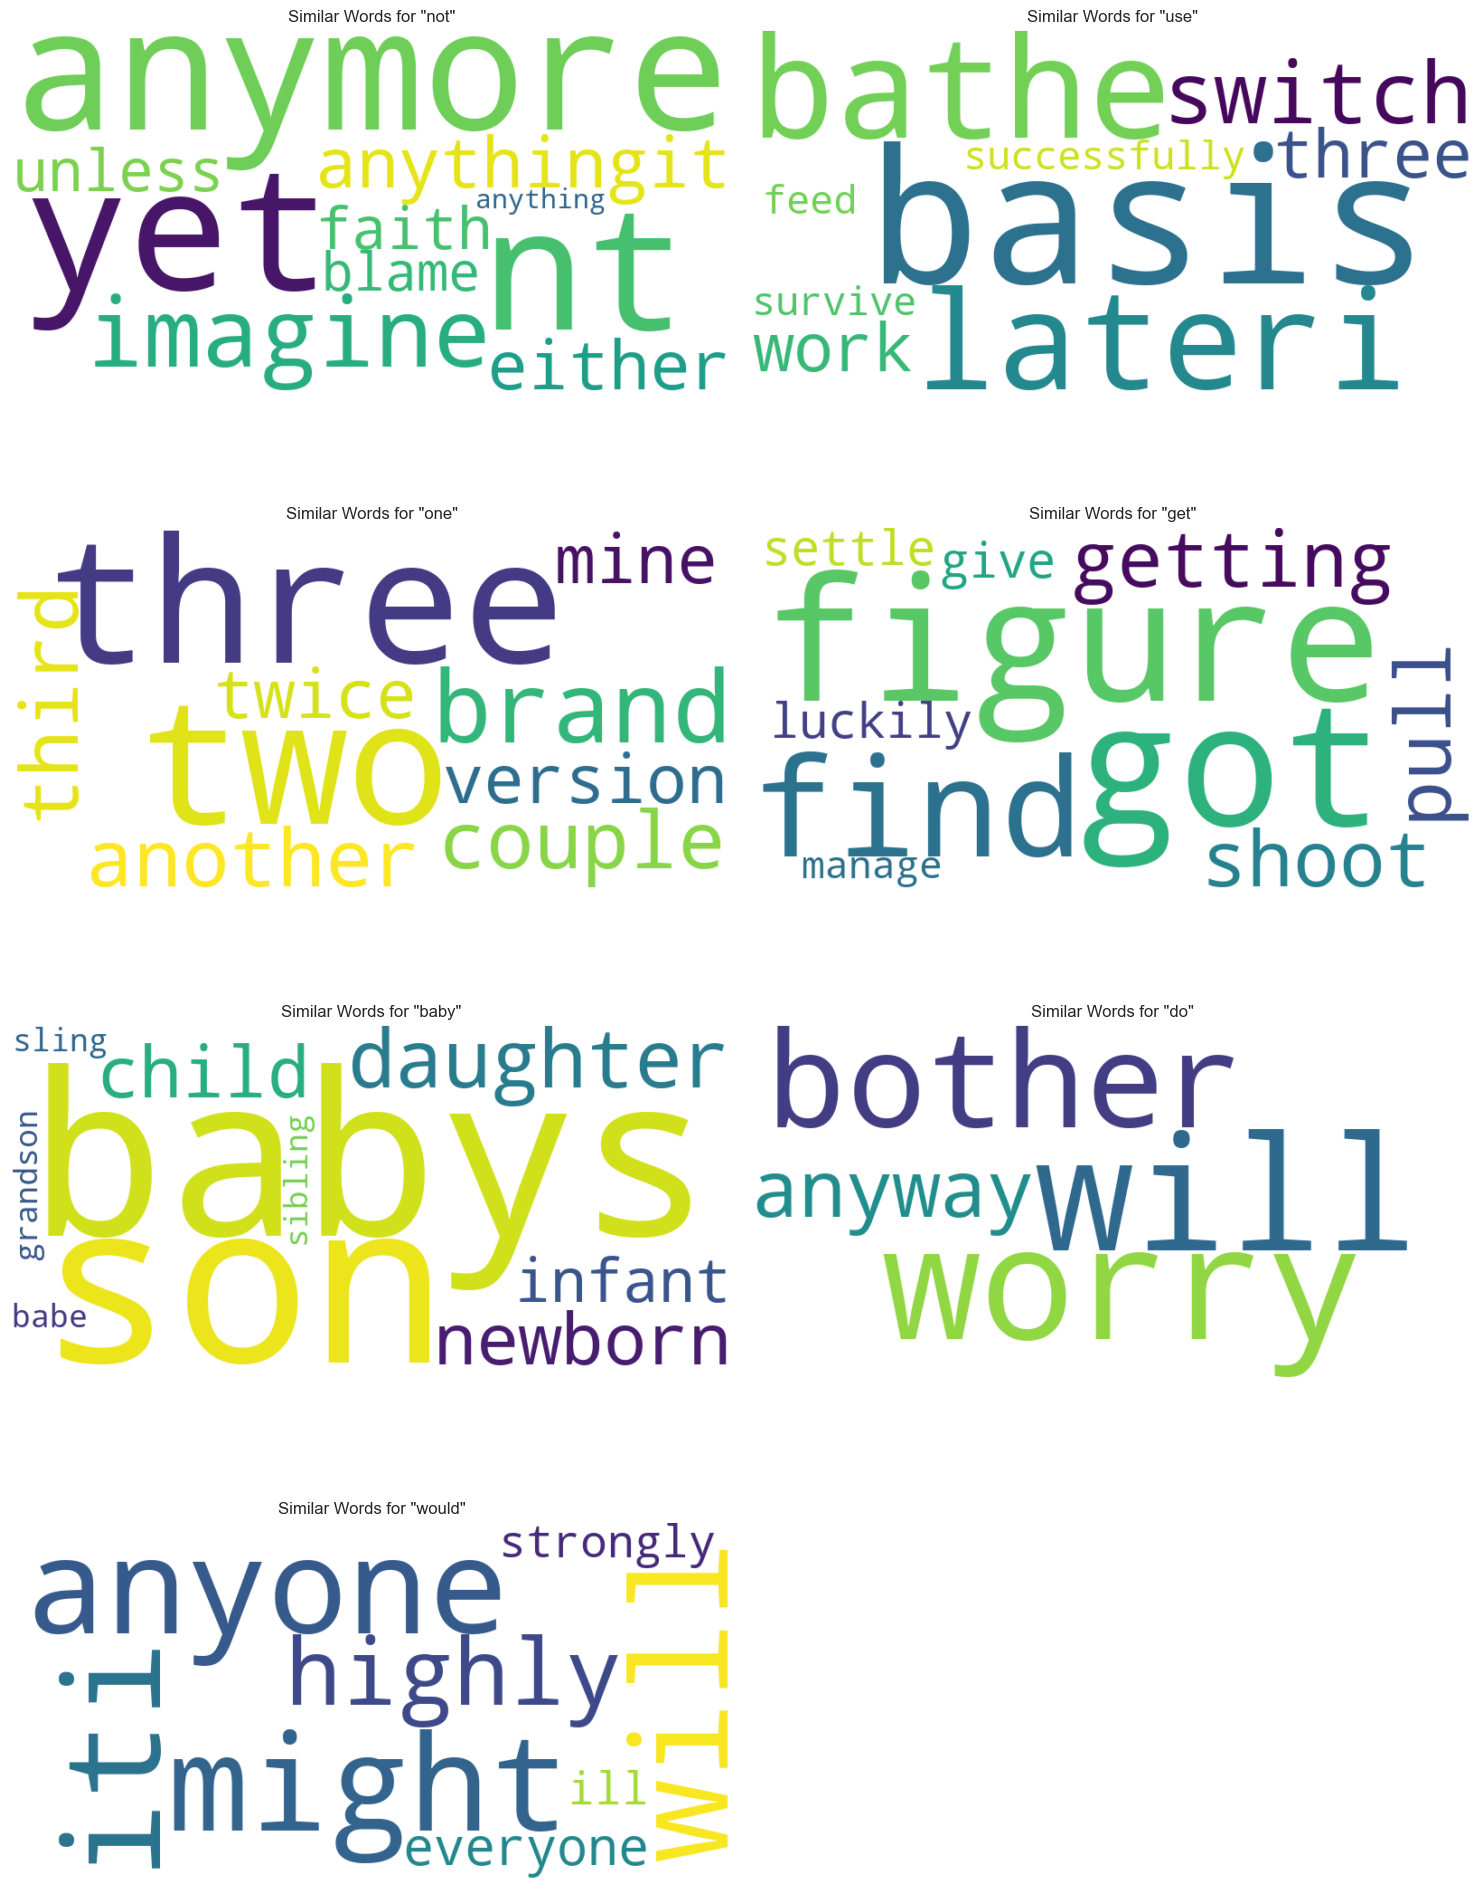

In [62]:
plot_similar_words(model=w2vec_model,most_common_words=most_common_words)

These similar words are determined by the context in which they commonly appear in the training data of the word2vec model. The model learns to associate words that tend to co-occur in similar sentences or contexts.

In [58]:
def create_document_embedding(tokens, model):
    valid_tokens = [token for token in tokens if token in model.wv.key_to_index]

    if valid_tokens:
        word_vectors = [model.wv.get_vector(token) for token in valid_tokens]
        # Normalize word vectors
        word_vectors = [vec / np.linalg.norm(vec) for vec in word_vectors]
        doc_embedding = np.mean(word_vectors, axis=0)
    else:
        doc_embedding = np.zeros(model.vector_size)

    return doc_embedding

# Create document embeddings for each row in the DataFrame
train_df['doc_embedding'] = train_df['tokenized_text'].apply(lambda x: create_document_embedding(x, w2vec_model))
test_df['doc_embedding'] = test_df['tokenized_text'].apply(lambda x: create_document_embedding(x, w2vec_model))

 Embedded Data 

In [59]:
train_df

,review,sentiment,tokenized_text,doc_embedding
168625,excellent product bc versatile easy clean baby...,1,"[excellent, product, bc, versatile, easy, clea...","[-0.03419969, 0.003637935, -0.016788157, 0.049..."
129802,product work well easy snap together take apar...,1,"[product, work, well, easy, snap, together, ta...","[0.021799004, 0.0016069368, 0.002227448, 0.028..."
47260,great chair would little tight large infant 10...,1,"[great, chair, would, little, tight, large, in...","[-0.0029459537, -0.012920816, 0.006781028, 0.0..."
169505,big fan bumgenius elemental find discontinue o...,1,"[big, fan, bumgenius, elemental, find, discont...","[0.011928798, 0.028081808, 0.015552059, 0.0504..."
151923,one page little one play every favorite item o...,1,"[one, page, little, one, play, every, favorite...","[0.022111172, 0.004924456, 0.0055755847, 0.005..."
...,...,...,...,...
28893,positivewe buy tub like clean water idea defin...,0,"[positivewe, buy, tub, like, clean, water, ide...","[-0.015480562, 0.015886068, 0.01145774, 0.0183..."
154170,product nice idea cheaply make receive gift th...,0,"[product, nice, idea, cheaply, make, receive, ...","[0.021550661, 0.015150729, 0.015490353, 0.0179..."
32153,purchase 3 first one open peel paint paint rus...,0,"[purchase, 3, first, one, open, peel, paint, p...","[0.005780485, 0.023825752, 0.008699036, 0.0446..."
105635,old fp light sound monitor 4 year finally died...,0,"[old, fp, light, sound, monitor, 4, year, fina...","[-0.014175498, 0.011997222, -0.0022446318, 0.0..."


In [60]:


test_df

,review,sentiment,tokenized_text,doc_embedding
157061,happy set color green pretty match light green...,1,"[happy, set, color, green, pretty, match, ligh...","[-0.002953663, 0.043578327, -0.025128225, 0.01..."
179407,great keeping snack son hard time get hand go ...,1,"[great, keeping, snack, son, hard, time, get, ...","[0.028449433, -0.0073629892, 0.009057535, 0.01..."
114531,purchase jumperoo grandaughter keep grams hous...,1,"[purchase, jumperoo, grandaughter, keep, grams...","[-0.0018526635, 0.0072839255, -0.0031807737, 0..."
63123,diaper great hold breastfe baby poop absorbant...,1,"[diaper, great, hold, breastfe, baby, poop, ab...","[0.011193554, 0.007173517, 0.008251425, 0.0463..."
31031,nursing cover useful take everywhere love see ...,1,"[nursing, cover, useful, take, everywhere, lov...","[-0.0019076876, 0.033608485, 0.0027614178, 0.0..."
...,...,...,...,...
160638,buy first model bc new mom baby do not sleep w...,0,"[buy, first, model, bc, new, mom, baby, do, no...","[0.011402064, -0.0066136047, -0.001928975, 0.0..."
125320,many new parent even realize mattress may fire...,0,"[many, new, parent, even, realize, mattress, m...","[-0.01898384, 0.035236698, 0.009789532, 0.0559..."
87001,toy bar stay place baby bouncer fall completel...,0,"[toy, bar, stay, place, baby, bouncer, fall, c...","[-0.03124407, 0.006378115, 0.023872584, 0.0518..."
46618,design mat bad strap intend hold mat car seat ...,0,"[design, mat, bad, strap, intend, hold, mat, c...","[-0.007873246, 0.02306045, 0.027070217, 0.0580..."


Saving Embedding Data

In [61]:
# Folder Path for Doc embedded data 
transformed_data_folder=os.path.join(os.getcwd(),'Data','transformed_data','Embedding_data')
# Making FolderFolder 
os.makedirs(transformed_data_folder,exist_ok=True)

# Saving  
train_file_path=os.path.join(transformed_data_folder,'train.csv')
test_file_path=os.path.join(transformed_data_folder,'test.csv')

# Saving CSV
save_dataframe_to_csv(dataframe=train_df,file_path=train_file_path)
save_dataframe_to_csv(dataframe=test_df,file_path=test_file_path)



### Train X and Y

In [62]:

X_train = np.vstack(train_df['doc_embedding'].values)
y_train = train_df['sentiment']  

X_test = np.vstack(test_df['doc_embedding'].values)
y_test = test_df['sentiment']  

Saving Embedded Data 

In [63]:
X_train_embedded=X_train.copy()
y_train_embedded=y_train.copy()

X_test_embedded=X_test.copy()
y_test_embedded=y_test.copy()


## PCA Transform

Principal Component Analysis (PCA) is a data analysis technique used to simplify complex datasets. It identifies the most important patterns in data by finding orthogonal linear combinations, known as principal components, that explain the maximum variance. PCA is employed for dimensionality reduction, noise reduction, and data visualization. It aids in simplifying high-dimensional data, removing noise, improving visualization, and creating new features for machine learning models. This technique is valuable for data analysis, enabling more efficient exploration of data patterns and relationships.

In [64]:
class EmbeddingReducer:
    def __init__(self, n_components=50):
        self.n_components = n_components
        self.pca = None  # Initialize PCA model attribute
        self.reduced_df = None

    def fit_transform(self, embeddings):
        """
        Fit PCA to the input embeddings and transform them to the reduced dimensionality.

        :param embeddings: A DataFrame column or a NumPy array containing embeddings.
        """
        if isinstance(embeddings, pd.Series):
            embeddings_array = np.array(embeddings.tolist())
        elif isinstance(embeddings, np.ndarray):
            embeddings_array = embeddings
        else:
            raise ValueError("Input embeddings must be a DataFrame column or a NumPy array.")
        
        # Fit PCA to the data and store the fitted model
        self.pca = PCA(n_components=self.n_components)
        reduced_embeddings = self.pca.fit_transform(embeddings_array)
        self.reduced_df = pd.DataFrame(reduced_embeddings, columns=[f'PCA_{i}' for i in range(self.n_components)])

    def get_reduced_dataframe(self):
        """
        Get the DataFrame containing the reduced embeddings.

        :return: A DataFrame with reduced embeddings.
        """
        if self.reduced_df is None:
            raise ValueError("Call fit_transform() first to reduce embeddings.")
        return self.reduced_df
    
    def get_pca_model(self):
        """
        Get the fitted PCA model.

        :return: The PCA model fitted to the data.
        """
        if self.pca is None:
            raise ValueError("Call fit_transform() first to fit PCA.")
        return self.pca
    
    def plot_variance_explained(self):
        """
        Plot the explained variance for each principal component.
        """
        # Check if data has been reduced
        if self.reduced_df is None:
            raise ValueError("Call fit_transform() first to compute explained variance.")

        # Calculate explained variance and cumulative variance
        explained_variance = self.pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)

        # Create a figure and set its size
        plt.figure(figsize=(8, 6))

        # Plot cumulative explained variance
        plt.plot(range(1, self.n_components + 1), cumulative_variance, marker='o', linestyle='--')

        # Set plot title and labels
        plt.title('Cumulative Explained Variance')
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Variance Explained')

        # Add a grid to the plot
        plt.grid()

        # Display the plot
        plt.show()

In [65]:
# Create an instance of EmbeddingReducer
reducer = EmbeddingReducer(n_components=50)
# Fit PCA and transform your embeddings
reducer.fit_transform(X_train)

# Fitted PCA Transform 
fitted_reducer=reducer.get_pca_model()

Cumulative Variance

Cumulative variance, in the context of Principal Component Analysis (PCA), is a measure that tells us how much of the total variance in the original dataset is explained by a subset of the principal components. It's computed by summing up the variances explained by each principal component in a cumulative manner.

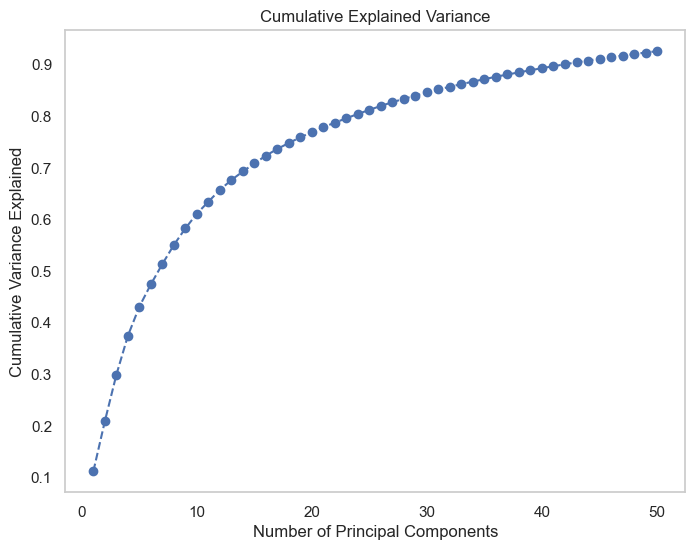

In [66]:
reducer.plot_variance_explained()

The selection of a set comprising 20 principal components, as obtained through the application of Principal Component Analysis (PCA)
This choice is predicated upon the compelling statistical evidence that these 20 components, when combined, elucidate approximately 71% of the aggregate variance inherent in the original dataset.

These 20 principal components to effectively encapsulate and succinctly represent a substantial segment of the underlying patterns and information encoded within the dataset. 

Choosing 20 Principal Components 

In [67]:
# Create an instance of EmbeddingReducer
pca = EmbeddingReducer(n_components=20)
# Fit PCA and transform your embeddings
pca.fit_transform(X_train)

# Fitted PCA Transform 
pca_model=pca.get_pca_model()

Transformed X_train and X_test

In [68]:
# Get the reduced embeddings DataFrame
X_train = pca.get_reduced_dataframe()

# Transform the test data using the same PCA model
X_test = pca_model.transform(X_test)


Saving Transformed Data 

In [69]:
def save_array_to_file(array, file_path):
    """
    Save a NumPy array to a file.

    Args:
    array (np.ndarray): The NumPy array to be saved.
    file_path (str): The file path where the array will be saved.
    """
    try:
        np.save(file_path, array)
        print(f"Array saved to {file_path}")
    except Exception as e:
        print(f"Error saving array to {file_path}: {e}")

In [70]:

# Folder Path for Doc embedded data 
transformed_data_folder=os.path.join(os.getcwd(),'Data','transformed_data','PCA_transformed_Data')
# Making FolderFolder 
os.makedirs(transformed_data_folder,exist_ok=True)

# Saving  
train_file_path=os.path.join(transformed_data_folder,'X_train')
test_file_path=os.path.join(transformed_data_folder,'X_test')

# Saving CSV
save_array_to_file(array=X_train,file_path=train_file_path)
save_array_to_file(array=X_test,file_path=test_file_path)

Array saved to e:\Projects\IIT Madras\Data\transformed_data\PCA_transformed_Data\X_train
Array saved to e:\Projects\IIT Madras\Data\transformed_data\PCA_transformed_Data\X_test


## Model Training

In [71]:

model_list = []
data_list=[]
def append_model_accuracy(model_name, accuracy,f1_score,data_list=data_list):
    """
    Appends a model name and its accuracy to a list of dictionaries.

    Parameters:
    - model_name (str): The name of the model.
    - accuracy (float): The accuracy of the model.
    - data_list (list of dict, optional): The list of dictionaries to which the data will be appended.
      If not provided, a new list will be created.

    Returns:
    - list of dict: The updated list of dictionaries with the new data.
    """

    data_list.append({"Model Name": model_name, "Accuracy": accuracy,"F1_score": f1_score})

    return data_list

### Logistic Regression


Logistic Regression is a fundamental algorithm in binary classification. It uses the sigmoid function to model probabilities between 0 and 1, making it suitable for tasks where the goal is to predict one of two outcomes.

In [72]:

class LogisticRegressionClassifier:
    def __init__(self, penalty='l2', C=1.0, random_state=None):
        """
        Initialize the Logistic Regression Classifier.

        Parameters:
        - penalty (str): 'l1' or 'l2', specifies the type of regularization (default: 'l2').
        - C (float): Inverse of regularization strength; smaller values specify stronger regularization (default: 1.0).
        - random_state (int): Seed for random number generation (default: None).
        """
        self.penalty = penalty
        self.C = C
        self.random_state = random_state
        self.model = SKLogisticRegression(penalty=penalty, C=C, random_state=random_state)

    def train(self, X_train, y_train):
        """
        Train the Logistic Regression classifier.

        Parameters:
        - X_train (array-like): Training data, shape (n_samples, n_features).
        - y_train (array-like): Target values, shape (n_samples,).

        Returns:
        - self: Returns the trained classifier.
        """
        self.model.fit(X_train, y_train)
        return self

    def predict(self, X_test):
        """
        Make predictions.

        Parameters:
        - X_test (array-like): Test data, shape (n_samples, n_features).

        Returns:
        - y_pred (array-like): Predicted labels, shape (n_samples,).
        """
        y_pred = self.model.predict(X_test)
        return y_pred
    
    def evaluate(self, X_test, y_test):
        """
        Evaluate the classifier's accuracy and F1 score on the test data.

        Parameters:
        - X_test (array-like): Test data, shape (n_samples, n_features).
        - y_test (array-like): True labels for the test data, shape (n_samples,).

        Returns:
        - accuracy (float): Accuracy of the classifier on the test data.
        - f1 (float): F1 score of the classifier on the test data.
        """
        y_pred = self.predict(X_test)
        accuracy = calculate_accuracy(y_test, y_pred)
        f1_score_value = calculate_f1_score(y_test, y_pred)
        
        # Create a list of evaluation metric names and corresponding values
        metrics = ['Accuracy', 'F1 Score']
        values = [accuracy, f1_score_value]
        
        # Plot the evaluation metrics as a grouped horizontal bar chart
        fig, ax = plt.subplots(figsize=(8, 6))
        y_pos = np.arange(len(metrics))
        bars = ax.barh(y_pos, values, color=['blue', 'green'])
        plt.xlabel('Score')
        plt.title('Accuracy and F1 Score')
        plt.yticks(y_pos, metrics)
        plt.grid(axis='x', linestyle='--', alpha=0.7)

        # Add data labels to the bars
        for bar, value in zip(bars, values):
            ax.text(value + 0.02, bar.get_y() + bar.get_height()/2, f'{value:.2f}', va='center')
        
        plt.show()
        
        return accuracy, f1_score_value

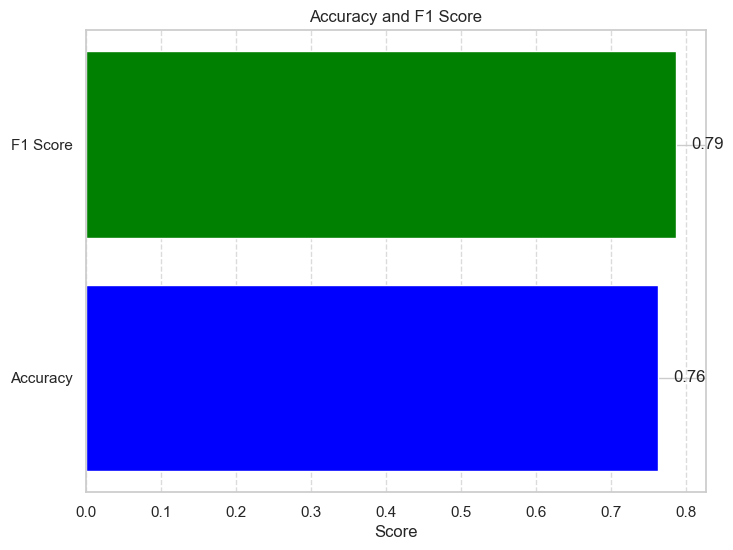

In [73]:
# Instantiate the KNNClassifier class
logistic_classifer = LogisticRegressionClassifier()

# Train the model
logistic_classifer.train(X_train, y_train)

# Evaluate the model
logistic_accuracy,f1_score=logistic_classifer.evaluate(X_test, y_test)


In [74]:
# Save Model To directory 
model_list.append(logistic_classifer.model)

In [75]:
result_df=append_model_accuracy(model_name='logistic_classifier',accuracy=logistic_accuracy,f1_score=f1_score)

In [76]:
print(f" Accurace of the Random Forest is {logistic_accuracy}")

 Accurace of the Random Forest is 0.7631689844079225


In [77]:
result_df

[{'Model Name': 'logistic_classifier',
  'Accuracy': 0.7631689844079225,
  'F1_score': 0.7873789346246973}]

2.   **Exercise 2**: **Implementation using K-Nearest Neighbor (KNN) Classifier**:  (1 point)

### KNN Classifier

The K-Nearest Neighbors (KNN) classifier is a simple and intuitive machine learning algorithm used for classification tasks. In KNN, an object is classified by a majority vote of its neighbors

With neighbor=5 in a K-Nearest Neighbors (KNN) classifier, it classifies a new data point by considering the five closest neighbors from the training data, determining the majority class among these neighbors, and assigning that class to the new data point.

In [78]:
class KNNClassifier:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.knn_classifier = KNeighborsClassifier(n_neighbors=self.n_neighbors)

    def train(self, X_train, y_train):
        # Optionally standardize features (you can enable/disable this)
        self.scaler = StandardScaler()
        X_train = self.scaler.fit_transform(X_train)

        # Train the KNN classifier
        self.knn_classifier.fit(X_train, y_train)

    def predict(self, X_test):
        # Optionally standardize features (using the same scaler)
        X_test = self.scaler.transform(X_test)

        # Make predictions
        return self.knn_classifier.predict(X_test)

    def evaluate(self, X_test, y_test):
        """
        Evaluate the classifier's accuracy and F1 score on the test data.

        Parameters:
        - X_test (array-like): Test data, shape (n_samples, n_features).
        - y_test (array-like): True labels for the test data, shape (n_samples,).

        Returns:
        - accuracy (float): Accuracy of the classifier on the test data.
        - f1 (float): F1 score of the classifier on the test data.
        """
        y_pred = self.predict(X_test)
        accuracy = calculate_accuracy(y_test, y_pred)
        f1_score_value = calculate_f1_score(y_test, y_pred)
        
        # Create a list of evaluation metric names and corresponding values
        metrics = ['Accuracy', 'F1 Score']
        values = [accuracy, f1_score_value]
        
        # Plot the evaluation metrics as a grouped horizontal bar chart
        fig, ax = plt.subplots(figsize=(8, 6))
        y_pos = np.arange(len(metrics))
        bars = ax.barh(y_pos, values, color=['blue', 'green'])
        plt.xlabel('Score')
        plt.title('Accuracy and F1 Score')
        plt.yticks(y_pos, metrics)
        plt.grid(axis='x', linestyle='--', alpha=0.7)

        # Add data labels to the bars
        for bar, value in zip(bars, values):
            ax.text(value + 0.02, bar.get_y() + bar.get_height()/2, f'{value:.2f}', va='center')
        
        plt.show()
        
        return accuracy, f1_score_value


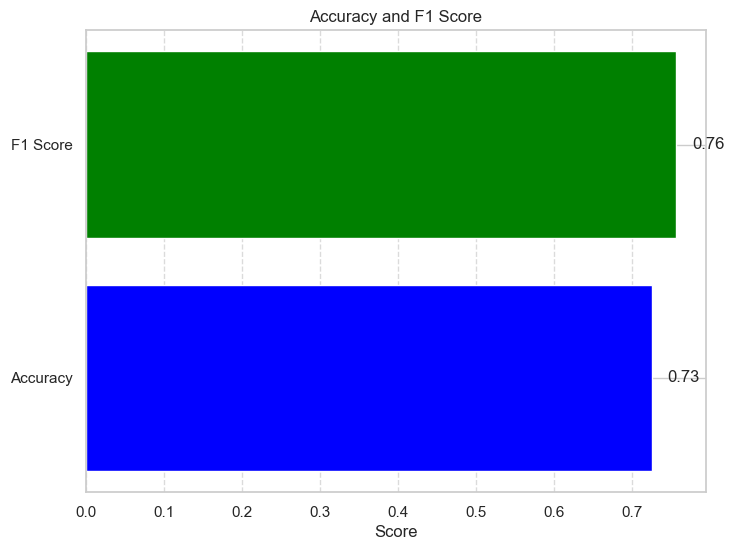

In [79]:
# Instantiate the KNNClassifier class
knn_model = KNNClassifier(n_neighbors=5)

# Train the model
knn_model.train(X_train, y_train)

# Evaluate the model
accuracy,f1_score=knn_model.evaluate(X_test, y_test)

In [80]:
model=knn_model.knn_classifier
# Save Model To directory 
model_list.append(model)

In [81]:
result_df=append_model_accuracy(model_name='knn_classifier',accuracy=accuracy,f1_score=f1_score)

3.   **Exercise 3**: **Implementation using Support Vector Machines (SVM) Classifier**:  (3 points)
      - First Reduce the features using PCA
      - use Hard-Margin Classifier
      - use Soft-Margin Classifier
      - use Kernel SVM Classifier

### SVM Classifier

A Support Vector Machine (SVM) is a supervised machine learning algorithm used for classification and regression tasks. It's particularly well-suited for binary classification problems, where it aims to find a decision boundary that best separates two classes in a feature space.



In classification, an SVM aims to find a hyperplane (a decision boundary) that maximizes the margin between two classes.
The hyperplane is chosen in such a way that it maximizes the distance between the nearest data points (support vectors) of each class to the hyperplane.
SVM can handle both linear and non-linear classification problems by using different types of kernels (e.g., linear, polynomial, radial basis function) to transform the data into a higher-dimensional space.


- Hard Margin SVM:

    - A Hard Margin SVM is an SVM with the strictest criteria for separating classes.
    - It aims to find a hyperplane that perfectly separates the two classes without any data points falling within the margin or on the wrong side of the decision boundary.
    - This approach is sensitive to outliers and noise in the data. If the data is not linearly separable or contains outliers, a Hard Margin SVM may fail to find a solution.

- Soft Margin SVM:

    - A Soft Margin SVM is a modification of the SVM that allows for some margin violations and errors in classification.
    - It introduces a regularization parameter (C) that controls the trade-off between maximizing the margin and minimizing classification errors.
    - A smaller value of C allows for a wider margin but may tolerate some misclassification, while a larger value of C seeks to minimize classification errors     even if it means a narrower margin.
    - Soft Margin SVMs are more robust to noisy data and data that is not perfectly separable.

In [82]:
class SVMClassifier:
    def __init__(self, C=1.0, kernel='linear', margin='soft'):
        """
        Initialize the SVM classifier with optional parameters.

        :param C: Regularization parameter (default: 1.0)
        :param kernel: Kernel type for SVM (default: 'linear')
        :param margin: Margin type ('hard' or 'soft', default: 'soft')
        """
        self.C = C
        self.kernel = kernel
        self.margin = margin
        self.svm_classifier = None

    def train(self, X_train, y_train):
        """
        Train the SVM classifier on the given training data.

        :param X_train: Training features
        :param y_train: Training labels
        """
        if self.margin == 'hard':
            self.C = 1000
        elif self.margin == 'soft':
            pass  # No need to change self.C for soft margin
        else:
            raise ValueError("Invalid margin type. Use 'hard' or 'soft'.")

        if self.kernel == 'linear':
            self.svm_classifier = SVC(C=self.C, kernel=self.kernel)
        elif self.kernel == 'rbf':
            self.svm_classifier = SVC(C=self.C, kernel=self.kernel, gamma='scale')
        elif self.kernel == 'poly':
            self.svm_classifier = SVC(C=self.C, kernel=self.kernel, degree=3)
        elif self.kernel == 'sigmoid':
            self.svm_classifier = SVC(C=self.C, kernel=self.kernel)
  
        self.svm_classifier.fit(X_train, y_train)

    def predict(self, X_test):
        """
        Make predictions using the trained classifier.

        :param X_test: Test features
        :return: Predicted labels
        """
        if self.svm_classifier is None:
            raise ValueError("Classifier has not been trained. Call train() first.")
        return self.svm_classifier.predict(X_test)

    def evaluate(self, X_test, y_test):
        """
        Evaluate the classifier's accuracy and F1 score on the test data.

        Parameters:
        - X_test (array-like): Test data, shape (n_samples, n_features).
        - y_test (array-like): True labels for the test data, shape (n_samples,).

        Returns:
        - accuracy (float): Accuracy of the classifier on the test data.
        - f1 (float): F1 score of the classifier on the test data.
        """
        y_pred = self.predict(X_test)
        accuracy = calculate_accuracy(y_test, y_pred)
        f1_score_value = calculate_f1_score(y_test, y_pred)
        
        # Create a list of evaluation metric names and corresponding values
        metrics = ['Accuracy', 'F1 Score']
        values = [accuracy, f1_score_value]
        
        # Plot the evaluation metrics as a grouped horizontal bar chart
        fig, ax = plt.subplots(figsize=(8, 6))
        y_pos = np.arange(len(metrics))
        bars = ax.barh(y_pos, values, color=['blue', 'green'])
        plt.xlabel('Score')
        plt.title('Accuracy and F1 Score')
        plt.yticks(y_pos, metrics)
        plt.grid(axis='x', linestyle='--', alpha=0.7)

        # Add data labels to the bars
        for bar, value in zip(bars, values):
            ax.text(value + 0.02, bar.get_y() + bar.get_height()/2, f'{value:.2f}', va='center')
        
        plt.show()
        
        return accuracy, f1_score_value

Soft Margin SVM 
   -  kernel - rbf

After conducting a thorough analysis of various kernel functions, it has been determined that the Radial Basis Function (RBF) kernel emerges as the optimal choice for achieving the highest accuracy on the current dataset within a Support Vector Machine (SVM) framework with a soft margin. 

In [83]:
score={}

Kernel:'rbf' 


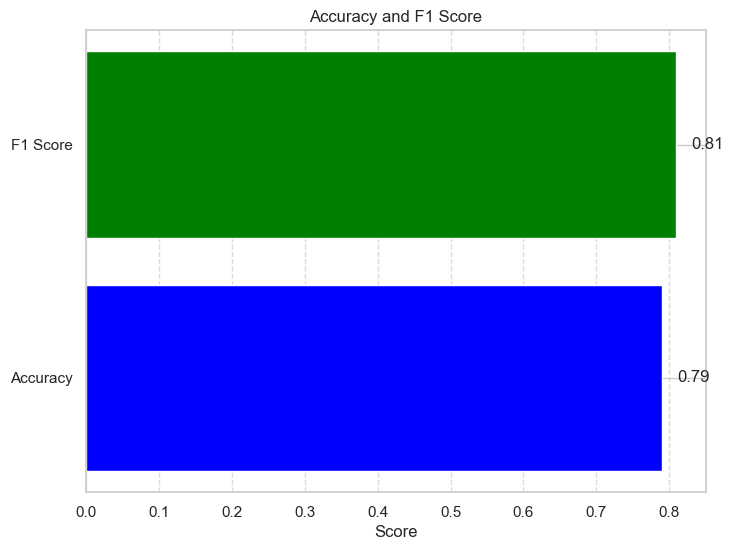

In [84]:
print(f"Kernel:'rbf' ")

kernel='rbf'

svm_soft_margin = SVMClassifier(kernel=kernel, margin='soft')
svm_soft_margin.train(X_train, y_train)
accuracy,f1_score = svm_soft_margin.evaluate(X_test, y_test)

score = {'kernel': kernel, 'Accuracy': accuracy,'f1_score':f1_score}

In [85]:
score

{'kernel': 'rbf',
 'Accuracy': 0.7903076274757691,
 'f1_score': 0.809815012994955}

In [86]:
result_df=append_model_accuracy(model_name='svm_soft_margin',accuracy=accuracy,f1_score=f1_score)

In [87]:
model_list.append(svm_soft_margin.svm_classifier)

Hard Margin SVM 
   -  kernel - Linear

After conducting a thorough analysis of various kernel functions, it has been determined that the Linear kernel emerges as the optimal choice for achieving the highest accuracy on the current dataset within a Support Vector Machine (SVM) framework with a Hard margin. 

Kernel:'Linear' 


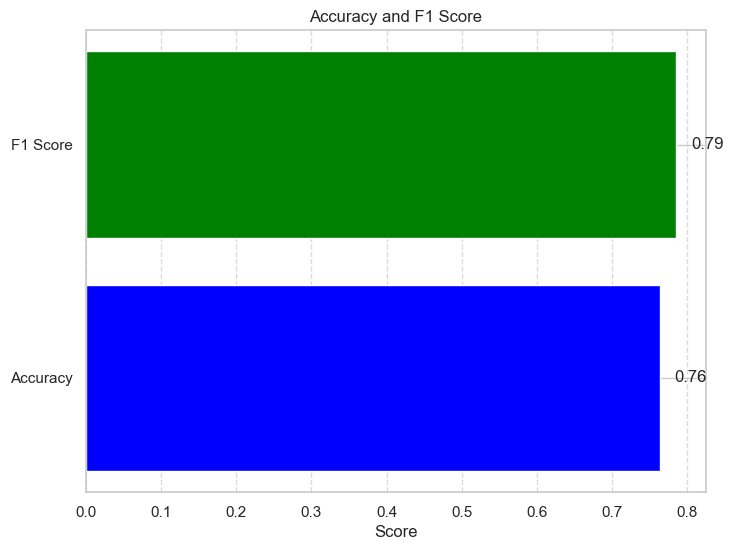

In [88]:
print(f"Kernel:'Linear' ")

kernel='linear'

svm_hard_margin = SVMClassifier(kernel=kernel, margin='hard')
svm_hard_margin.train(X_train, y_train)
accuracy,f1_score = svm_hard_margin.evaluate(X_test, y_test)

score = {'kernel': kernel, 'Accuracy': accuracy}

In [89]:
score

{'kernel': 'linear', 'Accuracy': 0.7635061104087653}

In [90]:

result_df=append_model_accuracy(model_name='svm_hard_margin',accuracy=accuracy,f1_score=f1_score)

In [91]:
model_list.append(svm_hard_margin.svm_classifier)

4.   **Exercise 4**: **Implementation using Decision Trees**:  (1 point)

### Random Forest 

A Random Forest classifier builds a "forest" of decision trees during training, where each tree learns to classify data independently. When making a prediction, it collects the votes or predictions from all the individual trees and selects the class with the most votes as the final prediction. This ensemble approach improves accuracy, reduces overfitting, and handles complex relationships in the data effectively. 

In [92]:

class RandomForestClassifier:
    def __init__(self, n_estimators=100, max_depth=None, random_state=None):
        """
        Initialize the Random Forest Classifier.

        Parameters:
        - n_estimators (int): The number of trees in the forest (default: 100).
        - max_depth (int): The maximum depth of the trees (default: None).
        - random_state (int): Seed for random number generation (default: None).
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.model = SKRandomForestClassifier(
            n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)

    def train(self, X_train, y_train):
        """
        Train the Random Forest classifier.

        Parameters:
        - X_train (array-like): Training data, shape (n_samples, n_features).
        - y_train (array-like): Target values, shape (n_samples,).

        Returns:
        - self: Returns the trained classifier.
        """
        self.model.fit(X_train, y_train)
        return self

    def predict(self, X_test):
        """
        Make predictions.

        Parameters:
        - X_test (array-like): Test data, shape (n_samples, n_features).

        Returns:
        - y_pred (array-like): Predicted labels, shape (n_samples,).
        """
        y_pred = self.model.predict(X_test)
        return y_pred

    def evaluate(self, X_test, y_test):
        """
        Evaluate the classifier's accuracy and F1 score on the test data.

        Parameters:
        - X_test (array-like): Test data, shape (n_samples, n_features).
        - y_test (array-like): True labels for the test data, shape (n_samples,).

        Returns:
        - accuracy (float): Accuracy of the classifier on the test data.
        - f1 (float): F1 score of the classifier on the test data.
        """
        y_pred = self.predict(X_test)
        accuracy = calculate_accuracy(y_test, y_pred)
        f1_score_value = calculate_f1_score(y_test, y_pred)
        
        # Create a list of evaluation metric names and corresponding values
        metrics = ['Accuracy', 'F1 Score']
        values = [accuracy, f1_score_value]
        
        # Plot the evaluation metrics as a grouped horizontal bar chart
        fig, ax = plt.subplots(figsize=(8, 6))
        y_pos = np.arange(len(metrics))
        bars = ax.barh(y_pos, values, color=['blue', 'green'])
        plt.xlabel('Score')
        plt.title('Accuracy and F1 Score')
        plt.yticks(y_pos, metrics)
        plt.grid(axis='x', linestyle='--', alpha=0.7)

        # Add data labels to the bars
        for bar, value in zip(bars, values):
            ax.text(value + 0.02, bar.get_y() + bar.get_height()/2, f'{value:.2f}', va='center')
        
        plt.show()
        
        return accuracy, f1_score_value


In [93]:
random_forest=RandomForestClassifier()
random_forest.train(X_train=X_train,y_train=y_train)

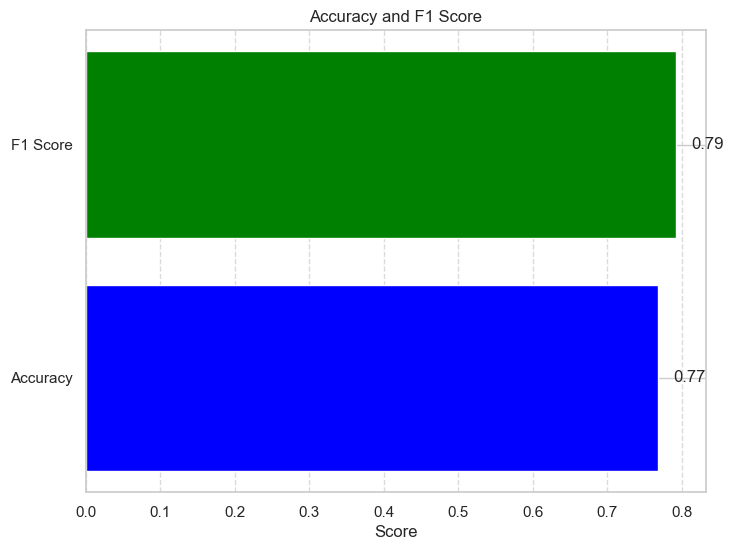

In [94]:

accuracy_score,f1_score=random_forest.evaluate(X_test=X_test,y_test=y_test)


In [95]:

print(f" Accurace of the Random Forest is {accuracy_score}")
print(f" F1_score of the Random Forest is {f1_score}")

 Accurace of the Random Forest is 0.768141592920354
 F1_score of the Random Forest is 0.792799578217971


In [96]:
result_df=append_model_accuracy(model_name='random_forest',accuracy=accuracy_score,f1_score=f1_score)

### Naive Bayes Classifier

Naive Bayes is a probabilistic algorithm that calculates the probability of a data point belonging to a particular class based on the probabilities of its features. It assumes that the features are independent, which simplifies the calculations. This algorithm is widely used in text and document classification tasks because of its speed and effectiveness.

In [97]:
class GaussianNaiveBayesClassifier:
    def __init__(self):
        """
        Initialize the Gaussian Naive Bayes Classifier.
        """
        self.model = GaussianNB()

    def train(self, X_train, y_train):
        """
        Train the Gaussian Naive Bayes classifier.

        Parameters:
        - X_train (array-like): Training data, shape (n_samples, n_features).
        - y_train (array-like): Target values, shape (n_samples,).

        Returns:
        - self: Returns the trained classifier.
        """
        self.model.fit(X_train, y_train)
        return self

    def predict(self, X_test):
        """
        Make predictions.

        Parameters:
        - X_test (array-like): Test data, shape (n_samples, n_features).

        Returns:
        - y_pred (array-like): Predicted labels, shape (n_samples,).
        """
        y_pred = self.model.predict(X_test)
        return y_pred
    def evaluate(self, X_test, y_test):
        """
        Evaluate the classifier's accuracy and F1 score on the test data.

        Parameters:
        - X_test (array-like): Test data, shape (n_samples, n_features).
        - y_test (array-like): True labels for the test data, shape (n_samples,).

        Returns:
        - accuracy (float): Accuracy of the classifier on the test data.
        - f1 (float): F1 score of the classifier on the test data.
        """
        y_pred = self.predict(X_test)
        accuracy = calculate_accuracy(y_test, y_pred)
        f1_score_value = calculate_f1_score(y_test, y_pred)
        
        # Create a list of evaluation metric names and corresponding values
        metrics = ['Accuracy', 'F1 Score']
        values = [accuracy, f1_score_value]
        
        # Plot the evaluation metrics as a grouped horizontal bar chart
        fig, ax = plt.subplots(figsize=(8, 6))
        y_pos = np.arange(len(metrics))
        bars = ax.barh(y_pos, values, color=['blue', 'green'])
        plt.xlabel('Score')
        plt.title('Accuracy and F1 Score')
        plt.yticks(y_pos, metrics)
        plt.grid(axis='x', linestyle='--', alpha=0.7)

        # Add data labels to the bars
        for bar, value in zip(bars, values):
            ax.text(value + 0.02, bar.get_y() + bar.get_height()/2, f'{value:.2f}', va='center')
        
        plt.show()
        
        return accuracy, f1_score_value

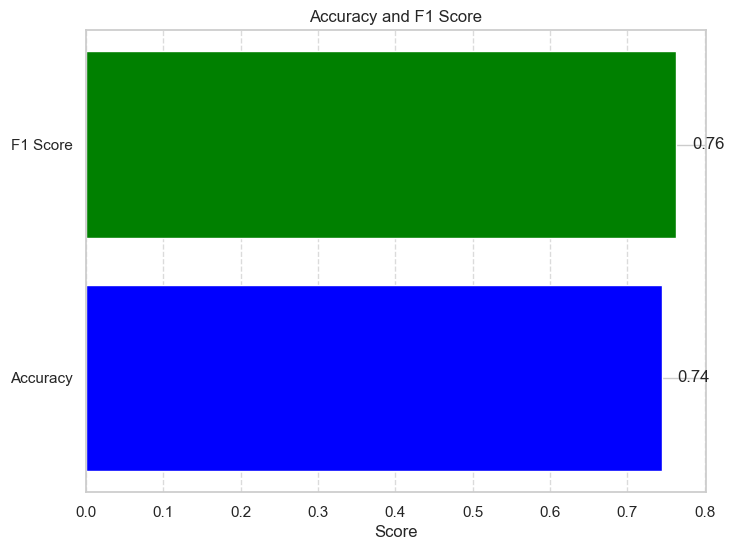

In [98]:
# Create and train the GNB classifier
GNB = GaussianNaiveBayesClassifier()
GNB.train(X_train, y_train)

# Make predictions
y_pred = GNB.predict(X_test)

# Evaluate accuracy
accuracy,f1_score = GNB.evaluate(X_test, y_test)

In [99]:
print("Accuracy:", accuracy)
print("F1_score:", f1_score)

Accuracy: 0.7446270543615676
F1_score: 0.7636136682789826


In [100]:
result_df=append_model_accuracy(model_name='Naive_Bayes',accuracy=accuracy,f1_score=f1_score)

In [101]:
model_list.append(GNB.model)

Result Dataframe 

In [102]:
df=pd.DataFrame(result_df)

In [103]:
df.columns


Index(['Model Name', 'Accuracy', 'F1_score'], dtype='object')

In [104]:
df

,Model Name,Accuracy,F1_score
0,logistic_classifier,0.763169,0.787379
1,knn_classifier,0.725242,0.756353
2,svm_soft_margin,0.790308,0.809815
3,svm_hard_margin,0.763506,0.785802
4,random_forest,0.768142,0.792800
5,Naive_Bayes,0.744627,0.763614


In [105]:
def plot_accuracy_and_f1_score(df):
    """
    Plot Accuracy and F1 Score separately for each Model Name in the given DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The input DataFrame containing 'Model Name', 'Accuracy', and 'F1_score' columns.
    """

    dataframe=df.copy()


    # Ensure the DataFrame contains the required columns
    if 'Model Name' not in dataframe.columns or 'Accuracy' not in dataframe.columns or 'F1_score' not in dataframe.columns:
        print("Error: DataFrame should have 'Model Name', 'Accuracy', and 'F1_score' columns.")
        return

    # Create a figure with two subplots
    plt.figure(figsize=(12, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    bars = plt.bar(dataframe['Model Name'], dataframe['Accuracy'], color='#1f77b4')
    plt.xlabel('Model Name')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for Different Models')
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

    # Add scores to the bars
    for bar, score in zip(bars, dataframe['Accuracy']):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.01, f'{score:.2f}', ha='center')

    # Plot F1 Score
    plt.subplot(1, 2, 2)
    bars = plt.bar(dataframe['Model Name'], dataframe['F1_score'], color='#ff7f0e')
    plt.xlabel('Model Name')
    plt.ylabel('F1 Score')
    plt.title('F1 Score for Different Models')
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

    # Add scores to the bars
    for bar, score in zip(bars, dataframe['F1_score']):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.01, f'{score:.2f}', ha='center')

    # Ensure proper spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()


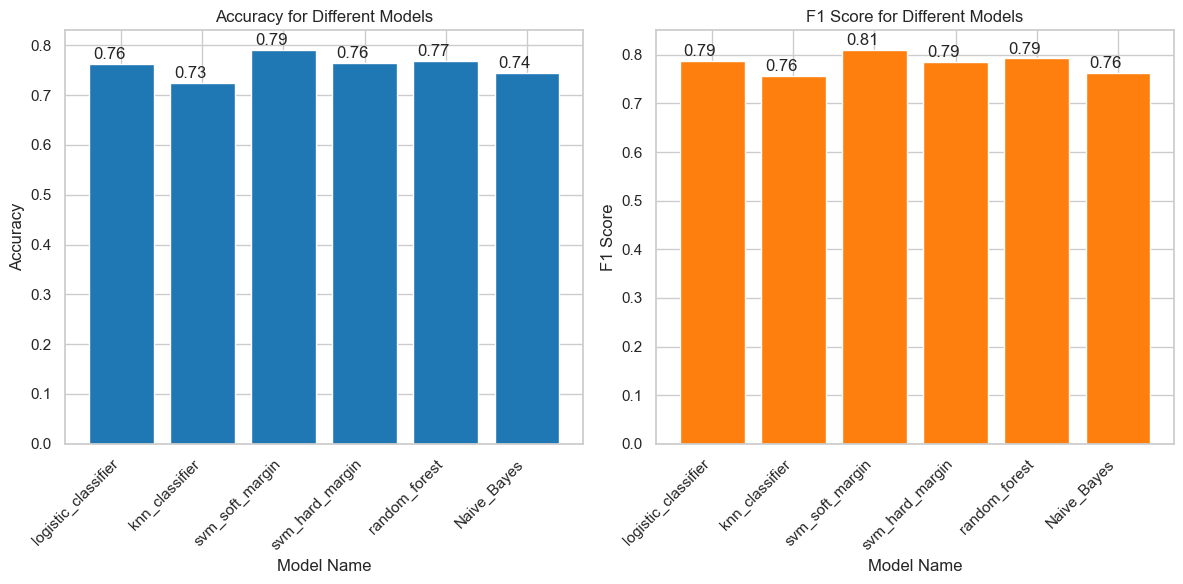

In [106]:
plot_accuracy_and_f1_score(df=df)

5.   **Exercise 5**: **Implementation using Ensemble Classifier**:  (2 point)
      - use LogisticRegression, KNN, SVM, and VotingClassifier as the weak classifiers

## Voting Classifier

A Voting Classifier is an ensemble machine learning model that amalgamates the predictions generated by multiple base classifiers, also known as "component classifiers" or "base learners," to arrive at a final classification decision. It falls under the category of ensemble learning, a technique that capitalizes on the strengths of diverse individual classifiers to enhance overall predictive performance and mitigate the risk of overfitting.

The fundamental concept behind a Voting Classifier lies in consolidating the forecasts from its constituent classifiers and determining the ultimate prediction through a defined criterion, such as a majority vote (in the context of classification tasks) or a weighted average (for regression tasks). Typically, three primary types of voting mechanisms are employed within a Voting Classifier:

- Hard Voting: 
    In hard voting, each individual base classifier issues a "vote" for a specific class label, and the final prediction is contingent on the majority vote. For instance, if three base classifiers yield two predictions for Class A and one for Class B, the ultimate prediction will favor Class A.

- Soft Voting: 
    Soft voting involves the provision of probability estimates (confidence scores) by the individual classifiers for each class. The final prediction is then derived by averaging these probabilities across all the base classifiers. This approach is particularly advantageous when the base classifiers can furnish probability estimates, such as those produced by logistic regression or support vector machines with probability outputs.


In [107]:
model_list

[LogisticRegression(),
 KNeighborsClassifier(),
 SVC(),
 SVC(C=1000, kernel='linear'),
 GaussianNB()]

In [108]:
knn_classifier=model_list[1]
logistic_regression=model_list[0]
SVM_soft_margin=model_list[2]
SVM_hard_margin=model_list[3]
GaussianNB=model_list[4]

In [109]:
classifiers = [
                ('KNN', knn_classifier),
                ('Logistic Regression', logistic_regression),
                ('SVM_soft_margin',SVM_soft_margin),
                ('SVM_hard_margin',SVM_hard_margin),
                ('GNB',GaussianNB)
            ]

In [110]:
class MyVotingClassifier:
    def __init__(self, classifiers, voting='hard'):
        """
        Initialize the MyVotingClassifier.

        Parameters:
        classifiers (list of tuples): A list of tuples containing (name, classifier) pairs.
        voting (str, optional): The type of voting. Defaults to 'hard'.
        """
        self.voting_classifier = VotingClassifier(estimators=classifiers, voting=voting)
        self.classifier_names = [name for name, _ in classifiers]
        self.best_classifier = None

    def fit(self, X_train, y_train):
        """
        Fit the voting classifier on the training data and select the best classifier.

        Parameters:
        X_train (array-like): The training input samples.
        y_train (array-like): The target values.
        """
        self.voting_classifier.fit(X_train, y_train)
        # Determine the best classifier based on training accuracy
        best_accuracy = 0
        for name, classifier in zip(self.classifier_names, self.voting_classifier.estimators_):
            accuracy = classifier.score(X_train, y_train)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                self.best_classifier = name

    def predict(self, X_test):
        """
        Make predictions using the voting classifier on test data.

        Parameters:
        X_test (array-like): The test input samples.

        Returns:
        array: Predicted target values.
        """
        return self.voting_classifier.predict(X_test)

    def evaluate(self, X_test, y_test):
        """
        Evaluate the classifier's accuracy and F1 score on the test data.

        Parameters:
        - X_test (array-like): Test data, shape (n_samples, n_features).
        - y_test (array-like): True labels for the test data, shape (n_samples,).

        Returns:
        - accuracy (float): Accuracy of the classifier on the test data.
        - f1 (float): F1 score of the classifier on the test data.
        """
        y_pred = self.predict(X_test)
        accuracy = calculate_accuracy(y_test, y_pred)
        f1_score_value = calculate_f1_score(y_test, y_pred)
        
        # Create a list of evaluation metric names and corresponding values
        metrics = ['Accuracy', 'F1 Score']
        values = [accuracy, f1_score_value]
        
        # Plot the evaluation metrics as a grouped horizontal bar chart
        fig, ax = plt.subplots(figsize=(8, 6))
        y_pos = np.arange(len(metrics))
        bars = ax.barh(y_pos, values, color=['blue', 'green'])
        plt.xlabel('Score')
        plt.title('Accuracy and F1 Score')
        plt.yticks(y_pos, metrics)
        plt.grid(axis='x', linestyle='--', alpha=0.7)

        # Add data labels to the bars
        for bar, value in zip(bars, values):
            ax.text(value + 0.02, bar.get_y() + bar.get_height()/2, f'{value:.2f}', va='center')
        
        plt.show()
        
        return accuracy, f1_score_value

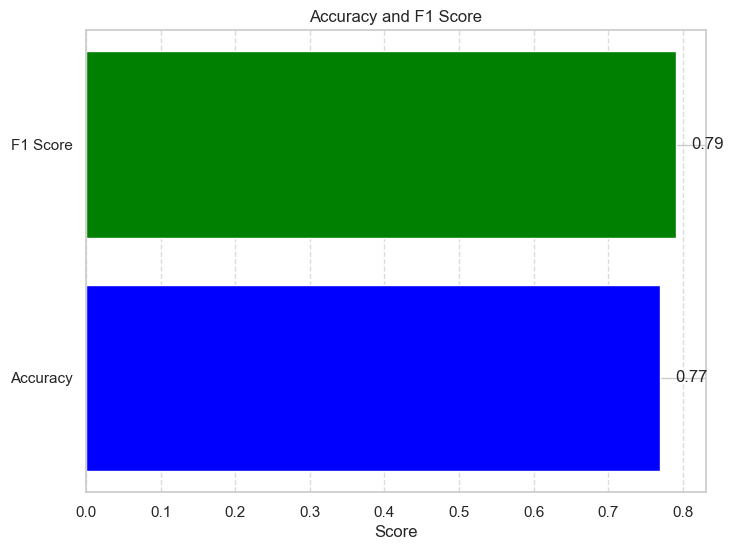

Best Classifier: KNN
Accuracy: 0.77
F1 Score: 0.79


In [111]:
# Initialize the custom voting classifier with weighted voting
voting_classifier = MyVotingClassifier(classifiers, voting='hard')

# Fit the ensemble classifier on the training data
voting_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = voting_classifier.predict(X_test)

# Evaluate the classifier's performance
accuracy, f1_score = voting_classifier.evaluate(X_test, y_test)

print(f"Best Classifier: {voting_classifier.best_classifier}")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1_score:.2f}")

In [112]:
voting_classifier_model=voting_classifier.voting_classifier

In [113]:
voting_classifier_model

VotingClassifier(estimators=[('KNN', KNeighborsClassifier()),
                             ('Logistic Regression', LogisticRegression()),
                             ('SVM_soft_margin', SVC()),
                             ('SVM_hard_margin', SVC(C=1000, kernel='linear')),
                             ('GNB', GaussianNB())])

6.   **Exercise 6**: **Implementation using Clustering**: (1 point)
      - k Means Clustering

## K means Clustering

K-Means groups data points into K clusters, where K is a predefined number. It works by iteratively assigning each data point to the nearest cluster center and then recalculating the cluster centers based on the data points in each cluster. This process continues until convergence, resulting in K clusters that represent meaningful patterns or groupings within the data


- No PCA:

Clustering is performed without prior dimensionality reduction using PCA. The original dataset retains its full set of features, and the clustering algorithm operates directly on these features. This approach is chosen when there is confidence that the complete set of original features is essential for the analysis or when the dimensionality of the data is already relatively low. It preserves the interpretability of the data in its original feature space, but may be less suitable for high-dimensional data where PCA can help mitigate the "curse of dimensionality" and improve clustering performance.


- Cluster=2 with PCA components=2:

In this configuration, a clustering algorithm, such as K-Means, is employed with a predetermined number of clusters (K=2). Prior to applying clustering, dimensionality reduction is carried out using Principal Component Analysis (PCA), resulting in the transformation of the original data into a lower-dimensional space characterized by two principal components. This technique serves to condense the feature space and capture the most significant variance within the data. Subsequently, the clustering algorithm groups data points into two clusters within this reduced feature space. This approach is particularly advantageous when working with high-dimensional data, as it simplifies the data representation and facilitates improved clustering outcomes and data visualization.


In [114]:


class KMeansClassifier:
    def __init__(self, n_clusters, random_state=None):
        """
        Initialize the K-Means Classifier.

        Parameters:
        - n_clusters (int): The number of clusters (default: 8).
        - random_state (int): Seed for random number generation (default: None).
        """
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.model = KMeans(n_clusters=n_clusters, random_state=random_state)
    def train(self, X_train, y_train):
        """
        Train the K-Means classifier.

        Parameters:
        - X_train (array-like): Training data, shape (n_samples, n_features).
        - y_train (array-like): Target values, shape (n_samples,).

        Returns:
        - self: Returns the trained classifier.
        """
        # Ensure that X_train is of float type (e.g., float32)
        X_train = X_train.astype('float32')

        self.model.fit(X_train)
        return self

    def predict(self, X_test):
        """
        Make predictions.

        Parameters:
        - X_test (array-like): Test data, shape (n_samples, n_features).

        Returns:
        - y_pred (array-like): Predicted labels, shape (n_samples,).
        """
        # Ensure that X_test is of float type (e.g., float32)
        X_test = X_test.astype('float32')

        # Use the cluster labels as predictions
        y_pred = self.model.predict(X_test)
        return y_pred

    def evaluate(self, X_test, y_test):
        """
        Evaluate the classifier's accuracy and F1 score on the test data.

        Parameters:
        - X_test (array-like): Test data, shape (n_samples, n_features).
        - y_test (array-like): True labels for the test data, shape (n_samples,).

        Returns:
        - accuracy (float): Accuracy of the classifier on the test data.
        - f1 (float): F1 score of the classifier on the test data.
        """
        y_pred = self.predict(X_test)
        accuracy = calculate_accuracy(y_test, y_pred)
        f1_score_value = calculate_f1_score(y_test, y_pred)
        
        # Create a list of evaluation metric names and corresponding values
        metrics = ['Accuracy', 'F1 Score']
        values = [accuracy, f1_score_value]
        
        # Plot the evaluation metrics as a grouped horizontal bar chart
        fig, ax = plt.subplots(figsize=(8, 6))
        y_pos = np.arange(len(metrics))
        bars = ax.barh(y_pos, values, color=['blue', 'green'])
        plt.xlabel('Score')
        plt.title('Accuracy and F1 Score')
        plt.yticks(y_pos, metrics)
        plt.grid(axis='x', linestyle='--', alpha=0.7)

        # Add data labels to the bars
        for bar, value in zip(bars, values):
            ax.text(value + 0.02, bar.get_y() + bar.get_height()/2, f'{value:.2f}', va='center')
        
        plt.show()
        
        return accuracy, f1_score_value

Reading Embedded Data ( Not PCA Transformed)

In [115]:
X_train=X_train_embedded
y_train=y_train_embedded

X_test=X_test_embedded
y_test=y_test_embedded

Without PCA Data 

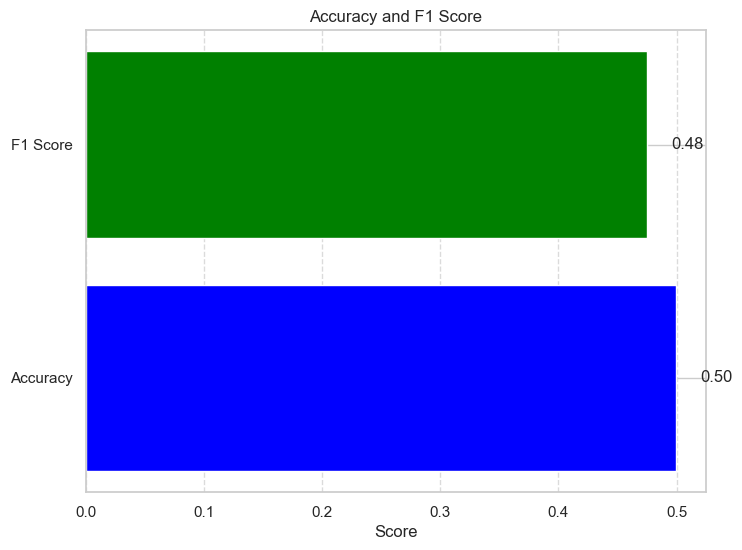

In [116]:
# Create and train the K-Means classifier
kmeans_classifier = KMeansClassifier(n_clusters=2, random_state=42)
kmeans_classifier.train(X_train, y_train)

# Make predictions
y_pred = kmeans_classifier.predict(X_test)

# Evaluate accuracy
accuracy,f1_score = kmeans_classifier.evaluate(X_test, y_test)


In [117]:
print("Accuracy:", accuracy)
print("F1_score:", f1_score)

Accuracy: 0.49987357774968394
F1_score: 0.47514594020873874


In [118]:
result_df=append_model_accuracy(model_name='kmeans_classifier',accuracy=accuracy,f1_score=f1_score)

####  PCA Data 

-  n_components = 2

In [119]:
X_train=X_train_embedded
y_train=y_train_embedded

X_test=X_test_embedded
y_test=y_test_embedded

In [120]:
X_train.dtype

dtype('float64')

In [121]:
X_test.dtype

dtype('float64')

In [122]:
# Create an instance of EmbeddingReducer
KNN_pca = EmbeddingReducer(n_components=2)
# Fit PCA and transform your embeddings
KNN_pca.fit_transform(X_train)

# Fitted PCA Transform 
KNN_pca_fit=KNN_pca.get_pca_model()

# Get the reduced embeddings DataFrame
X_train = KNN_pca.get_reduced_dataframe()

# Transform the test data using the same PCA model
X_test = KNN_pca_fit.transform(X_test)

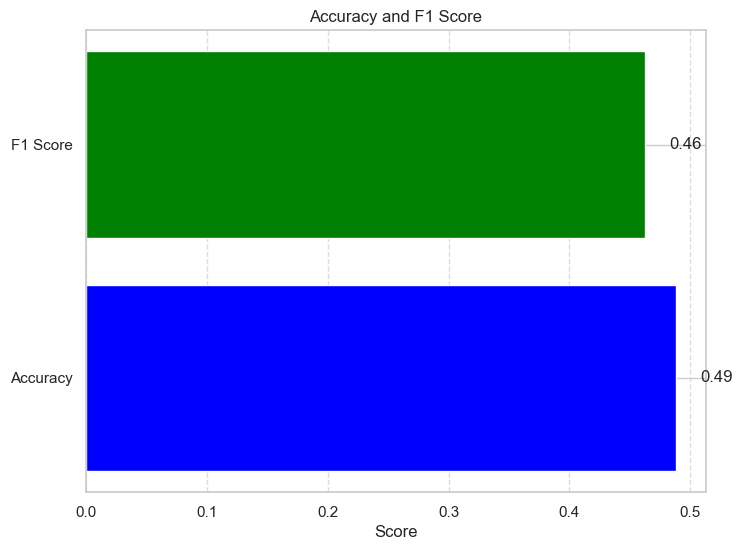

In [123]:
# Create and train the K-Means classifier
kmeans_classifier = KMeansClassifier(n_clusters=2, random_state=42)
kmeans_classifier.train(X_train, y_train)

# Make predictions
y_pred = kmeans_classifier.predict(X_test)

# Evaluate accuracy
accuracy,f1_score = kmeans_classifier.evaluate(X_test, y_test)


In [124]:
print("Accuracy:", accuracy)
print("F1_score:", f1_score)

Accuracy: 0.48857985672144966
F1_score: 0.46243798724309


In [125]:
result_df=append_model_accuracy(model_name='kmeans_classifier_PCA',accuracy=accuracy,f1_score=f1_score)

In [126]:
df=pd.DataFrame(result_df)

In [127]:
df

,Model Name,Accuracy,F1_score
0,logistic_classifier,0.763169,0.787379
1,knn_classifier,0.725242,0.756353
2,svm_soft_margin,0.790308,0.809815
3,svm_hard_margin,0.763506,0.785802
4,random_forest,0.768142,0.792800
5,Naive_Bayes,0.744627,0.763614
6,kmeans_classifier,0.499874,0.475146
7,kmeans_classifier_PCA,0.488580,0.462438


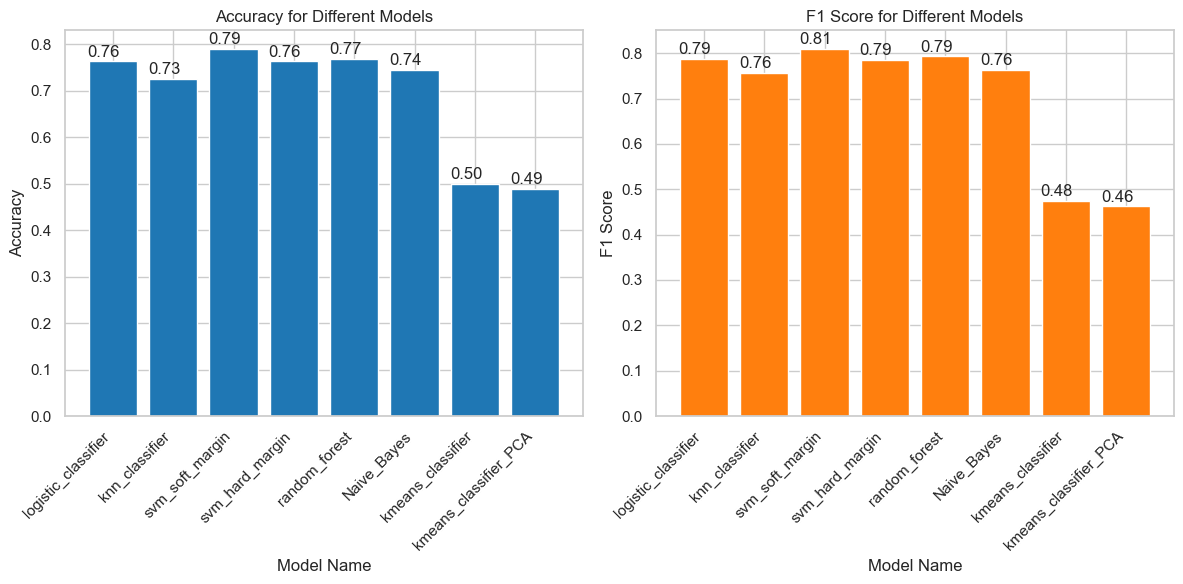

In [128]:
plot_accuracy_and_f1_score(df=df)

In [129]:
voting_classifier_model

VotingClassifier(estimators=[('KNN', KNeighborsClassifier()),
                             ('Logistic Regression', LogisticRegression()),
                             ('SVM_soft_margin', SVC()),
                             ('SVM_hard_margin', SVC(C=1000, kernel='linear')),
                             ('GNB', GaussianNB())])

7.   **Exercise 7**: **Test your own sentence**: (1 point)
      - Input your sentences ( One for positive and negative each)
      - Print the output sentiment.

# Prediction

Example 


Positive Sentiment:

    - "I'm thrilled with my new smartphone from Amazon. It has a fantastic camera and a long-lasting battery."
    - "The quality of the product exceeded my expectations. It's a great value for the price."



Negative Sentiment:

    - "This product is a complete disappointment. It broke after just a few weeks of use."
    - "The seller on Amazon sent me the wrong item, and it's been a hassle trying to get a refund."
    - "I wouldn't recommend this laptop. It's slow and constantly freezes."

In [130]:
# Take input from the user
user_input = input("Enter a sentence: ")

In [145]:
# Append the user input to the DataFrame
df =pd.DataFrame([{'review': user_input}])

# Print the DataFrame to verify the result
print(df)

                                              review
0  I'm thrilled with my new smartphone from Amazo...


Basic Pre-Processing

In [146]:
# Initialize the TextPreprocessor class
text_processor = TextPreprocessor(df, 'review')


# Perform text preprocessing tasks
text_processor.remove_punctuation()
text_processor.remove_special_characters()
text_processor.remove_stopwords()
text_processor.lowercase()


df=text_processor.processed_data()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hitesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [147]:
df

,review
0,im thrilled new smartphone amazon fantastic ca...


Lemmetization

In [148]:
df=lemmatizer.lemmatize_dataframe_column(dataframe=df,column_label='review')

Tokenize data

In [149]:
df=tokenize_text_column(data=df,text_column='review')

Word2VEc

In [150]:

# Create document embeddings for each row in the DataFrame
df['doc_embedding'] = df['tokenized_text'].apply(lambda x: create_document_embedding(x, w2vec_model))

In [151]:
df

,review,tokenized_text,doc_embedding
0,I m thrilled new smartphone amazon fantastic c...,"[I, m, thrilled, new, smartphone, amazon, fant...","[0.028449126, 0.05138056, -0.042564962, 0.0186..."


Model 

In [152]:
df['doc_embedding']

0    [0.028449126, 0.05138056, -0.042564962, 0.0186...
Name: doc_embedding, dtype: object

In [153]:
test = np.vstack(df['doc_embedding'].values)

In [154]:
df=pca_model.transform(test)

In [155]:
# Make predictions on the test data
y_pred = voting_classifier.predict(df)

In [156]:
y_pred

array([1], dtype=int64)

In [157]:
def predict_sentiment(y_pred):
    if y_pred == 0:
        return "negative"
    elif y_pred == 1:
        return "positive"
    else:
        return "unknown"

In [158]:
sentiment = predict_sentiment(y_pred)
print(f"Sentiment: {sentiment}")


Sentiment: positive
